In [332]:
!pip install --upgrade osmnx

python(49542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Attempting uninstall: osmnx
    Found existing installation: osmnx 2.0.5
    Uninstalling osmnx-2.0.5:
      Successfully uninstalled osmnx-2.0.5

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


# 🔋 EV Charging Station Optimization & Profit Prediction 🔋

## My company is looking for investing in EV Charging Stations in Shenzhen, China. They want to build 3 new stations. My job is to help them, given the locations and performance of the current working stations, find uncovered spots within the city. 

## Using a rich dataset of existing EV infrastructure including demand (volume), pricing (electricity & service fees), site metadata, weather, and geographic information we aim to:

### - 📍 Locate underserved areas within Shenzhen where EV charging stations are sparse but demand is potentially high (high demand - low supply) 
### - 🧠 Analyze historical performance of existing stations to understand what drives high usage and profitability.
### - 📈 Predict future station performance, including:
####      Revenue and costs (electricity and service fees)
####      Profitability per hour/day/month
####      Return on Investment (ROI)

## Goals: 

### 1. Find suitable locations to place a EV Charging station in Shenzhen, China. HOW? 🧐:
#### Find uncovered urban areas with high residential or commercial activity
#### Low competition zones with sparse existing station density (based on distance between charging stations)

### 2. 🌧 Weather-dependent patterns (do people charge more when it’s rainy or cold? or they rather stay at home?)
### 3. High-volume stations’s traits to generalize success factors (what makes the other stations profitable?) How?:
####   Find the financial metrics of each charging station to assess whether new stations would be profitable.
### 4. Clustering/prediction: 
#### 🏗 Construction cost? We will estimate fixed cost of building based on real Shenzhen figures
#### 🔌 Power capacity. Will new location handle expected demand?
#### 💵 Estimated demand & revenue
#### 📉 Risk modeling (sesitivity analysis). What if energy prices go up 📈 or demand drops 📉?

### 5. Business simulation. Best location proposal, ROI, time to break even



## What is the purpose?:
### Value for investors, urban planners, sustainability...


# What do we as Data Sciencists expect?
## We expect to find at least 6 optimal locations (my company is only able to build 3 stations)
## What will the approach be?:
### - Data Preprocessing: Clean and merge datasets
### - Exploratory Data Analysis: Understand trends, station utilization, and pricing structures
### - Location Analysis: Use geospatial data to find underserved areas
### - Predictive Modeling: Estimate volume, profit, and ROI for new sites using clustering and supervised ML models
### - Visualization: Maps and charts to communicate spatial and financial insights

# What data do we have?:
## Sites: Locations and metadata of 1379 real charging stations
## Volume & Duration: Hourly charging demand and session lengths
## E-Price & S-Price: Hourly electricity cost and service fees
## POIs: Points of Interest near stations (residential, commercial, cinema, parking...) using point of interest from OpenStreetMap
## Distance: Matrix of inter-site distances
## Weather: Hourly weather data from Visual Crossing API
## Pending to get: Population distribution map on coordinates 113.784724, 114.062996, 22.46557, 22.592883.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import folium
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

In [3]:
volume = pd.read_csv("volume.csv", parse_dates=True, index_col=0)
duration = pd.read_csv("duration.csv", parse_dates=True, index_col=0)
e_price = pd.read_csv("e_price.csv", parse_dates=True, index_col=0)
s_price = pd.read_csv("s_price.csv", parse_dates=True, index_col=0)
sites = pd.read_csv("sites.csv")

In [4]:
print(volume.shape)
print(duration.shape)
print(e_price.shape)
print(s_price.shape)
print(sites.shape)

(4392, 1379)
(4392, 1379)
(4392, 1379)
(4392, 1379)
(1379, 9)


In [5]:
print(sites.index.equals(sites.index))
print(sites.isna().sum().sum()) 

True
0


In [6]:
site_0 = volume.columns[0]
site_0

'0'

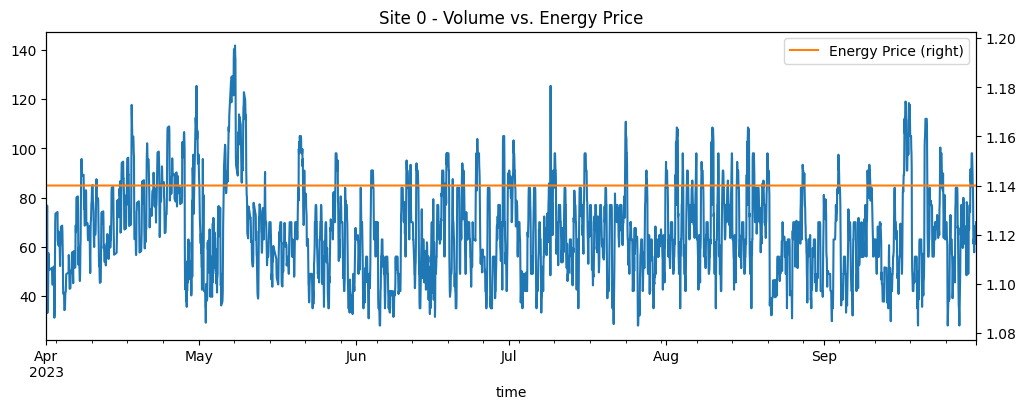

In [7]:
plt.figure(figsize=(12,4))
volume[site_0].plot(label="Volume (kWh)")
e_price[site_0].plot(label="Energy Price", secondary_y=True)
plt.title(f"Site {site_0} - Volume vs. Energy Price")
plt.legend()
plt.show()

In [8]:
for df in [volume, duration, e_price, s_price]:
    df.columns = df.columns.astype(str)

In [9]:
volume_long = volume.reset_index().melt(id_vars='index', var_name='site_id', value_name='volume')
duration_long = duration.reset_index().melt(id_vars='index', var_name='site_id', value_name='duration')
e_price_long = e_price.reset_index().melt(id_vars='time', var_name='site_id', value_name='e_price')
s_price_long = s_price.reset_index().melt(id_vars='time', var_name='site_id', value_name='s_price')

for df in [volume_long, duration_long]:
    df.rename(columns={'index': 'timestamp'}, inplace=True)
for df in [e_price_long, s_price_long]:
    df.rename(columns={'time': 'timestamp'}, inplace=True)

In [10]:
dfs = [volume_long, duration_long, e_price_long, s_price_long]

df_full = reduce(lambda left, right: pd.merge(left, right, on=['timestamp', 'site_id']), dfs)

In [12]:
sites['site'] = sites['site'].astype(str)
df_full = df_full.merge(sites, left_on='site_id', right_on='site')

In [14]:
poi = pd.read_csv("poi.csv")
poi['type'].unique()

array(['other', 'fuel', 'fire_station', 'hospital', 'cinema',
       'restaurant', 'fast_food', 'bank', 'cafe', 'kindergarten', 'taxi',
       'parking', 'parking_entrance', 'conference_centre', 'toilets',
       'post_office', 'vending_machine', 'bus_station', 'bicycle_rental',
       'atm', 'marketplace', 'post_box', 'school', 'pharmacy',
       'nightclub', 'place_of_worship', 'bench', 'bar', 'pub',
       'ice_cream', 'fountain', 'charging_station', 'clinic', 'shelter',
       'library', 'car_rental', 'bicycle_parking', 'telephone',
       'recycling', 'waste_basket', 'doctors', 'police', 'border_control',
       'food_court', 'waste_disposal', 'karaoke_box', 'veterinary',
       'bureau_de_change', 'bread', 'college', 'townhall', 'arts_centre',
       'public_bath', 'drinking_water', 'ferry_terminal', 'lounge',
       'water_point', 'childcare', 'waste_transfer_station',
       'driving_school', 'hunting_stand', 'dentist', 'clock',
       'school gate', 'community_centre', 'cantee

In [15]:
print(df_full['longitude'].min(), df_full['longitude'].max())
print(df_full['latitude'].min(), df_full['latitude'].max())

113.784724 114.516991
22.46557 22.818918


In [16]:
bounding_boxes = [113.784724, 114.516991, 22.46557, 22.818918]

In [17]:
lat_min, lat_max = 22.46557, 22.818918
lon_min, lon_max = 113.784724, 114.516991
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

map_szx= folium.Map(location=[center_lat, center_lon], zoom_start=11)

folium.Rectangle(
    bounds=[[lat_min, lon_min], [lat_max, lon_max]],
    color="blue", fill=True, fill_opacity=0.1
).add_to(map_szx)

# Show the map
map_szx

In [18]:
df_full.reset_index(drop=True, inplace=True)
df_full

timestamp site_id      volume   duration  e_price  s_price  \
0       2023-04-01 00:00:00       0   48.416667   6.916667     1.14     1.14   
1       2023-04-01 01:00:00       0   37.982671   5.426096     1.14     1.14   
2       2023-04-01 02:00:00       0   40.382008   5.768858     1.14     1.14   
3       2023-04-01 03:00:00       0   41.614679   5.944954     1.14     1.14   
4       2023-04-01 04:00:00       0   40.514016   5.787717     1.14     1.14   
...                     ...     ...         ...        ...      ...      ...   
6056563 2023-09-30 19:00:00     999  151.643333  21.663333     0.00     0.00   
6056564 2023-09-30 20:00:00     999  151.620000  21.660000     0.00     0.00   
6056565 2023-09-30 21:00:00     999  151.596667  21.656667     0.00     0.00   
6056566 2023-09-30 22:00:00     999  151.573333  21.653333     0.00     0.00   
6056567 2023-09-30 23:00:00     999  151.550000  21.650000     0.00     0.00   

        site   longitude   latitude  charger_num  total_duration  \
0          0  114.142651  22.547750            4    77594.572675   
1          0  114.142651  22.547750            4    77594.572675   
2          0  114.142651  22.547750            4    77594.572675   
3          0  114.142651  22.547750            4    77594.572675   
4          0  114.142651  22.547750            4    77594.572675   
...      ...         ...        ...          ...             ...   
6056563  999  114.039323  22.550918            2   190767.416667   
6056564  999  114.039323  22.550918            2   190767.416667   
6056565  999  114.039323  22.550918            2   190767.416667   
6056566  999  114.039323  22.550918            2   190767.416667   
6056567  999  114.039323  22.550918            2   190767.416667   

         total_volume  avg_power   perimeter         area  
0        5.431620e+05        7.0  431.915270  12419.71939  
1        5.431620e+05        7.0  431.915270  12419.71939  
2        5.431620e+05        7.0  431.915270  12419.71939  
3        5.431620e+05        7.0  431.915270  12419.71939  
4        5.431620e+05        7.0  431.915270  12419.71939  
...               ...        ...         ...          ...  
6056563  1.335372e+06        7.0  275.299989   6012.06507  
6056564  1.335372e+06        7.0  275.299989   6012.06507  
6056565  1.335372e+06        7.0  275.299989   6012.06507  
6056566  1.335372e+06        7.0  275.299989   6012.06507  
6056567  1.335372e+06        7.0  275.299989   6012.06507  

[6056568 rows x 15 columns]

In [19]:
distance = pd.read_csv('distance.csv')

In [20]:
distance.columns

Index(['Unnamed: 0', '0', '1', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1434', '1436', '1437', '1438', '1439', '1440', '1441', '1442', '1443',
       '1444'],
      dtype='object', length=1380)

In [21]:
distance = distance.rename(columns={'Unnamed: 0': 'from_site_id'})

distance_long = distance.melt(id_vars='from_site_id', 
                                     var_name='to_site_id', 
                                     value_name='distance')
distance_long

from_site_id to_site_id   distance
0                   0          0   0.000000
1                   1          0   2.496200
2                   3          0   3.515668
3                   4          0   4.375921
4                   5          0   2.933117
...               ...        ...        ...
1901636          1440       1444  18.537879
1901637          1441       1444  27.970158
1901638          1442       1444  33.077632
1901639          1443       1444  21.127366
1901640          1444       1444   0.000000

[1901641 rows x 3 columns]

In [22]:
distance_long['from_site_id'] = distance_long['from_site_id'].astype(int)
distance_long['to_site_id'] = distance_long['to_site_id'].astype(int)

In [23]:
distance_long

from_site_id  to_site_id   distance
0                   0           0   0.000000
1                   1           0   2.496200
2                   3           0   3.515668
3                   4           0   4.375921
4                   5           0   2.933117
...               ...         ...        ...
1901636          1440        1444  18.537879
1901637          1441        1444  27.970158
1901638          1442        1444  33.077632
1901639          1443        1444  21.127366
1901640          1444        1444   0.000000

[1901641 rows x 3 columns]

In [24]:
unique_sites_ids = df_full['site_id'].unique().astype(int)

In [25]:
distance_long = distance_long[
    distance_long['from_site_id'].isin(unique_sites_ids) &
    distance_long['to_site_id'].isin(unique_sites_ids)
]

In [26]:
unique_sites = df_full.drop_duplicates(subset='site_id')[['latitude', 'longitude']]
unique_sites

latitude   longitude
0        22.547750  114.142651
4392     22.541244  114.119416
8784     22.542691  114.065040
13176    22.574182  114.112399
17568    22.539617  114.099783
...            ...         ...
6034608  22.590903  114.059013
6039000  22.591356  114.056366
6043392  22.593201  114.060064
6047784  22.536691  114.016845
6052176  22.550918  114.039323

[1379 rows x 2 columns]

In [27]:
for _, row in unique_sites.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_szx)
map_szx

In [289]:
missing_price = df_full[(df_full['e_price'] == 0.0) | (df_full['s_price'] == 0.0)]
#print(f"{len(missing_price)} rows with 0 pricing out of {len(df_full)} total rows")
df_full

timestamp site_id      volume   duration  e_price  s_price  \
0       2023-04-01 00:00:00    1001    5.250000   0.750000      0.0      0.0   
1       2023-04-01 01:00:00    1001    5.250000   0.750000      0.0      0.0   
2       2023-04-01 02:00:00    1001    5.250000   0.750000      0.0      0.0   
3       2023-04-01 03:00:00    1001    5.250000   0.750000      0.0      0.0   
4       2023-04-01 04:00:00    1001    5.250000   0.750000      0.0      0.0   
...                     ...     ...         ...        ...      ...      ...   
2178427 2023-09-30 19:00:00     999  151.643333  21.663333      0.0      0.0   
2178428 2023-09-30 20:00:00     999  151.620000  21.660000      0.0      0.0   
2178429 2023-09-30 21:00:00     999  151.596667  21.656667      0.0      0.0   
2178430 2023-09-30 22:00:00     999  151.573333  21.653333      0.0      0.0   
2178431 2023-09-30 23:00:00     999  151.550000  21.650000      0.0      0.0   

         site   longitude   latitude  charger_num  total_duration  \
0        1001  114.053016  22.522570            2     6454.951579   
1        1001  114.053016  22.522570            2     6454.951579   
2        1001  114.053016  22.522570            2     6454.951579   
3        1001  114.053016  22.522570            2     6454.951579   
4        1001  114.053016  22.522570            2     6454.951579   
...       ...         ...        ...          ...             ...   
2178427   999  114.039323  22.550918            2   190767.416667   
2178428   999  114.039323  22.550918            2   190767.416667   
2178429   999  114.039323  22.550918            2   190767.416667   
2178430   999  114.039323  22.550918            2   190767.416667   
2178431   999  114.039323  22.550918            2   190767.416667   

         total_volume  avg_power   perimeter         area  
0        4.518466e+04        7.0  275.270048  6010.830856  
1        4.518466e+04        7.0  275.270048  6010.830856  
2        4.518466e+04        7.0  275.270048  6010.830856  
3        4.518466e+04        7.0  275.270048  6010.830856  
4        4.518466e+04        7.0  275.270048  6010.830856  
...               ...        ...         ...          ...  
2178427  1.335372e+06        7.0  275.299989  6012.065070  
2178428  1.335372e+06        7.0  275.299989  6012.065070  
2178429  1.335372e+06        7.0  275.299989  6012.065070  
2178430  1.335372e+06        7.0  275.299989  6012.065070  
2178431  1.335372e+06        7.0  275.299989  6012.065070  

[2178432 rows x 15 columns]

In [290]:
avg_e_price = df_full[df_full['e_price'] > 0]['e_price'].mean()
avg_s_price = df_full[df_full['s_price'] > 0]['s_price'].mean()
print(avg_e_price,avg_s_price)

0.7710902054829318 0.7710902054829318


In [110]:
bins = [0, 6.9, 22, 60, 150, 360]  # Approximate thresholds for AC slow, AC fast, DC fast, superchargers
labels = ['AC_slow', 'AC_fast', 'DC_slow', 'DC_fast', 'Ultra_fast']
df_full['power_class'] = pd.cut(df_full['avg_power'], bins=bins, labels=labels)
df_full

timestamp site_id      volume   duration e_price s_price  \
0       2023-04-01 00:00:00       0   48.416667   6.916667     0.9     0.9   
1       2023-04-01 01:00:00       0   37.982671   5.426096     0.9     0.9   
2       2023-04-01 02:00:00       0   40.382008   5.768858     0.9     0.9   
3       2023-04-01 03:00:00       0   41.614679   5.944954     0.9     0.9   
4       2023-04-01 04:00:00       0   40.514016   5.787717     0.9     0.9   
...                     ...     ...         ...        ...     ...     ...   
6047779 2023-09-30 19:00:00     999  151.643333  21.663333     0.9     0.9   
6047780 2023-09-30 20:00:00     999  151.620000  21.660000     0.9     0.9   
6047781 2023-09-30 21:00:00     999  151.596667  21.656667     0.9     0.9   
6047782 2023-09-30 22:00:00     999  151.573333  21.653333     0.9     0.9   
6047783 2023-09-30 23:00:00     999  151.550000  21.650000     0.9     0.9   

          longitude   latitude  charger_num  avg_power  ...    revenue  \
0        114.142651  22.547750            4        7.0  ...      87.15   
1        114.142651  22.547750            4        7.0  ...  68.368807   
2        114.142651  22.547750            4        7.0  ...  72.687615   
3        114.142651  22.547750            4        7.0  ...  74.906422   
4        114.142651  22.547750            4        7.0  ...  72.925229   
...             ...        ...          ...        ...  ...        ...   
6047779  114.039323  22.550918            2        7.0  ...       79.2   
6047780  114.039323  22.550918            2        7.0  ...       79.2   
6047781  114.039323  22.550918            2        7.0  ...       79.2   
6047782  114.039323  22.550918            2        7.0  ...       79.2   
6047783  114.039323  22.550918            2        7.0  ...       79.2   

              cost     profit rated_power  max_possible_energy  volume_clean  \
0           43.575     43.575        22.0                 88.0     48.416667   
1        34.184404  34.184404        22.0                 88.0     37.982671   
2        36.343807  36.343807        22.0                 88.0     40.382008   
3        37.453211  37.453211        22.0                 88.0     41.614679   
4        36.462615  36.462615        22.0                 88.0     40.514016   
...            ...        ...         ...                  ...           ...   
6047779       39.6       39.6        22.0                 44.0     44.000000   
6047780       39.6       39.6        22.0                 44.0     44.000000   
6047781       39.6       39.6        22.0                 44.0     44.000000   
6047782       39.6       39.6        22.0                 44.0     44.000000   
6047783       39.6       39.6        22.0                 44.0     44.000000   

         total_volume_clean  total_duration_clean         district population  
0              284993.16577          41664.097558   luohu district  1143801.0  
1              284993.16577          41664.097558   luohu district  1143801.0  
2              284993.16577          41664.097558   luohu district  1143801.0  
3              284993.16577          41664.097558   luohu district  1143801.0  
4              284993.16577          41664.097558   luohu district  1143801.0  
...                     ...                   ...              ...        ...  
6047779        193248.00000          95662.991667  futian district  1553225.0  
6047780        193248.00000          95662.991667  futian district  1553225.0  
6047781        193248.00000          95662.991667  futian district  1553225.0  
6047782        193248.00000          95662.991667  futian district  1553225.0  
6047783        193248.00000          95662.991667  futian district  1553225.0  

[6047784 rows x 21 columns]

In [29]:
df_full[['e_price', 's_price']] = df_full[['e_price', 's_price']].replace(0.0, pd.NA)

In [112]:
df_full.groupby('power_class')[['e_price', 's_price']].median()

/var/folders/sp/j31td69s1fsg02f7tz1kfv9m0000gn/T/ipykernel_57797/961729883.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_full.groupby('power_class')[['e_price', 's_price']].median()


e_price s_price
power_class                
AC_slow         0.7     0.7
AC_fast         0.9     0.9
DC_slow         1.1     1.1
DC_fast         1.3     1.3
Ultra_fast      1.7     1.7

In [203]:
price_map = {
    'AC_slow': 0.7,
    'AC_fast': 0.9,
    'DC_slow': 1.0,
    'DC_fast': 1.2,
    'Ultra_fast': 1.5
}
for pc, price in price_map.items():
    df_full.loc[df_full['power_class'] == pc, 'e_price'] = price
    df_full.loc[df_full['power_class'] == pc, 's_price'] = price

In [113]:
df_full[df_full['power_class'] == 'DC_slow'].nunique()

timestamp                4392
site_id                    15
volume                  10231
duration                 7032
e_price                     1
s_price                     1
longitude                  15
latitude                   15
charger_num                 3
avg_power                  10
power_class                 1
revenue                  3811
cost                     3811
profit                   3811
rated_power                 1
max_possible_energy         3
volume_clean             3826
total_volume_clean         14
total_duration_clean       14
district                    6
population                  6
dtype: int64

In [114]:
df_full['revenue'] = df_full['volume'] * (df_full['e_price'] + df_full['s_price'])
df_full['cost'] = df_full['volume'] * df_full['e_price']
df_full['profit'] = df_full['revenue'] -  df_full['cost']
df_full.head()

timestamp site_id     volume  duration e_price s_price  \
0 2023-04-01 00:00:00       0  48.416667  6.916667     0.9     0.9   
1 2023-04-01 01:00:00       0  37.982671  5.426096     0.9     0.9   
2 2023-04-01 02:00:00       0  40.382008  5.768858     0.9     0.9   
3 2023-04-01 03:00:00       0  41.614679  5.944954     0.9     0.9   
4 2023-04-01 04:00:00       0  40.514016  5.787717     0.9     0.9   

    longitude  latitude  charger_num  avg_power  ...    revenue       cost  \
0  114.142651  22.54775            4        7.0  ...      87.15     43.575   
1  114.142651  22.54775            4        7.0  ...  68.368807  34.184404   
2  114.142651  22.54775            4        7.0  ...  72.687615  36.343807   
3  114.142651  22.54775            4        7.0  ...  74.906422  37.453211   
4  114.142651  22.54775            4        7.0  ...  72.925229  36.462615   

      profit rated_power  max_possible_energy  volume_clean  \
0     43.575        22.0                 88.0     48.416667   
1  34.184404        22.0                 88.0     37.982671   
2  36.343807        22.0                 88.0     40.382008   
3  37.453211        22.0                 88.0     41.614679   
4  36.462615        22.0                 88.0     40.514016   

   total_volume_clean  total_duration_clean        district population  
0        284993.16577          41664.097558  luohu district  1143801.0  
1        284993.16577          41664.097558  luohu district  1143801.0  
2        284993.16577          41664.097558  luohu district  1143801.0  
3        284993.16577          41664.097558  luohu district  1143801.0  
4        284993.16577          41664.097558  luohu district  1143801.0  

[5 rows x 21 columns]

In [35]:
df_full['avg_power'].nunique()

223

In [37]:
df_full.loc[df_full['duration'] == 0][['volume','duration']].nunique()

volume      1
duration    1
dtype: int64

In [36]:
df_full.loc[df_full['duration'] == 0, 'volume'] = 0

In [38]:
df_full.loc[df_full['avg_power'] == 150]

timestamp site_id  volume   duration e_price s_price site  \
241560  2023-04-01 00:00:00     105  4200.0  28.000000     1.7     1.7  105   
241561  2023-04-01 01:00:00     105  4200.0  28.000000     1.7     1.7  105   
241562  2023-04-01 02:00:00     105  4200.0  28.000000     1.7     1.7  105   
241563  2023-04-01 03:00:00     105  4200.0  28.000000     1.7     1.7  105   
241564  2023-04-01 04:00:00     105  4200.0  28.000000     1.7     1.7  105   
...                     ...     ...     ...        ...     ...     ...  ...   
5481211 2023-09-30 19:00:00      87   375.0   2.500000     1.7     1.7   87   
5481212 2023-09-30 20:00:00      87   200.0   1.333333     1.7     1.7   87   
5481213 2023-09-30 21:00:00      87   200.0   1.333333     1.7     1.7   87   
5481214 2023-09-30 22:00:00      87   300.0   2.000000     1.7     1.7   87   
5481215 2023-09-30 23:00:00      87   250.0   1.666667     1.7     1.7   87   

          longitude   latitude  charger_num  total_duration  total_volume  \
241560   113.968312  22.565812            1   245280.000000  3.679200e+07   
241561   113.968312  22.565812            1   245280.000000  3.679200e+07   
241562   113.968312  22.565812            1   245280.000000  3.679200e+07   
241563   113.968312  22.565812            1   245280.000000  3.679200e+07   
241564   113.968312  22.565812            1   245280.000000  3.679200e+07   
...             ...        ...          ...             ...           ...   
5481211  114.146513  22.603742            2    22425.609063  3.363841e+06   
5481212  114.146513  22.603742            2    22425.609063  3.363841e+06   
5481213  114.146513  22.603742            2    22425.609063  3.363841e+06   
5481214  114.146513  22.603742            2    22425.609063  3.363841e+06   
5481215  114.146513  22.603742            2    22425.609063  3.363841e+06   

         avg_power   perimeter         area power_class  revenue    cost  \
241560       150.0  275.315740  6012.714318  Ultra_fast  14280.0  7140.0   
241561       150.0  275.315740  6012.714318  Ultra_fast  14280.0  7140.0   
241562       150.0  275.315740  6012.714318  Ultra_fast  14280.0  7140.0   
241563       150.0  275.315740  6012.714318  Ultra_fast  14280.0  7140.0   
241564       150.0  275.315740  6012.714318  Ultra_fast  14280.0  7140.0   
...            ...         ...          ...         ...      ...     ...   
5481211      150.0  275.355914  6014.370201  Ultra_fast   1275.0   637.5   
5481212      150.0  275.355914  6014.370201  Ultra_fast    680.0   340.0   
5481213      150.0  275.355914  6014.370201  Ultra_fast    680.0   340.0   
5481214      150.0  275.355914  6014.370201  Ultra_fast   1020.0   510.0   
5481215      150.0  275.355914  6014.370201  Ultra_fast    850.0   425.0   

         profit  
241560   7140.0  
241561   7140.0  
241562   7140.0  
241563   7140.0  
241564   7140.0  
...         ...  
5481211   637.5  
5481212   340.0  
5481213   340.0  
5481214   510.0  
5481215   425.0  

[48312 rows x 19 columns]

In [304]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178432 entries, 0 to 2178431
Data columns (total 19 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       datetime64[ns]
 1   site_id         object        
 2   volume          float64       
 3   duration        float64       
 4   e_price         object        
 5   s_price         object        
 6   site            object        
 7   longitude       float64       
 8   latitude        float64       
 9   charger_num     int64         
 10  total_duration  float64       
 11  total_volume    float64       
 12  avg_power       float64       
 13  perimeter       float64       
 14  area            float64       
 15  power_class     category      
 16  revenue         object        
 17  cost            object        
 18  profit          object        
dtypes: category(1), datetime64[ns](1), float64(9), int64(1), object(7)
memory usage: 301.2+ MB


In [71]:
df_full['avg_power'].max()

360.0

In [61]:
rated_power_map = {
    'AC_slow': 7,
    'AC_fast': 22,
    'DC_slow': 60,
    'DC_fast': 150,
    'Ultra_fast': 360
}

df_full['rated_power'] = df_full['power_class'].map(rated_power_map)
df_full['rated_power'] = df_full['rated_power'].astype(float)
df_full['max_possible_energy'] = df_full['charger_num'] * df_full['rated_power'] * 1  # 1 hour
df_full['volume_clean'] = (df_full['avg_power'] * df_full['duration']).clip(upper=df_full['max_possible_energy'])

In [115]:
df_full['revenue'] = df_full['volume_clean'] * (df_full['e_price'] + df_full['s_price'])
df_full['cost'] = df_full['volume_clean'] * df_full['e_price']
df_full['profit'] = df_full['revenue'] -  df_full['cost']

In [64]:
df_full

timestamp site_id      volume   duration e_price s_price  \
0       2023-04-01 00:00:00       0   48.416667   6.916667     0.9     0.9   
1       2023-04-01 01:00:00       0   37.982671   5.426096     0.9     0.9   
2       2023-04-01 02:00:00       0   40.382008   5.768858     0.9     0.9   
3       2023-04-01 03:00:00       0   41.614679   5.944954     0.9     0.9   
4       2023-04-01 04:00:00       0   40.514016   5.787717     0.9     0.9   
...                     ...     ...         ...        ...     ...     ...   
6056563 2023-09-30 19:00:00     999  151.643333  21.663333     0.9     0.9   
6056564 2023-09-30 20:00:00     999  151.620000  21.660000     0.9     0.9   
6056565 2023-09-30 21:00:00     999  151.596667  21.656667     0.9     0.9   
6056566 2023-09-30 22:00:00     999  151.573333  21.653333     0.9     0.9   
6056567 2023-09-30 23:00:00     999  151.550000  21.650000     0.9     0.9   

        site   longitude   latitude  charger_num  total_duration  \
0          0  114.142651  22.547750            4    77594.572675   
1          0  114.142651  22.547750            4    77594.572675   
2          0  114.142651  22.547750            4    77594.572675   
3          0  114.142651  22.547750            4    77594.572675   
4          0  114.142651  22.547750            4    77594.572675   
...      ...         ...        ...          ...             ...   
6056563  999  114.039323  22.550918            2   190767.416667   
6056564  999  114.039323  22.550918            2   190767.416667   
6056565  999  114.039323  22.550918            2   190767.416667   
6056566  999  114.039323  22.550918            2   190767.416667   
6056567  999  114.039323  22.550918            2   190767.416667   

         total_volume  avg_power power_class    revenue       cost     profit  \
0        5.431620e+05        7.0     AC_fast      87.15     43.575     43.575   
1        5.431620e+05        7.0     AC_fast  68.368807  34.184404  34.184404   
2        5.431620e+05        7.0     AC_fast  72.687615  36.343807  36.343807   
3        5.431620e+05        7.0     AC_fast  74.906422  37.453211  37.453211   
4        5.431620e+05        7.0     AC_fast  72.925229  36.462615  36.462615   
...               ...        ...         ...        ...        ...        ...   
6056563  1.335372e+06        7.0     AC_fast       79.2       39.6       39.6   
6056564  1.335372e+06        7.0     AC_fast       79.2       39.6       39.6   
6056565  1.335372e+06        7.0     AC_fast       79.2       39.6       39.6   
6056566  1.335372e+06        7.0     AC_fast       79.2       39.6       39.6   
6056567  1.335372e+06        7.0     AC_fast       79.2       39.6       39.6   

         rated_power  max_possible_energy  volume_clean  
0               22.0                 88.0     48.416667  
1               22.0                 88.0     37.982671  
2               22.0                 88.0     40.382008  
3               22.0                 88.0     41.614679  
4               22.0                 88.0     40.514016  
...              ...                  ...           ...  
6056563         22.0                 44.0     44.000000  
6056564         22.0                 44.0     44.000000  
6056565         22.0                 44.0     44.000000  
6056566         22.0                 44.0     44.000000  
6056567         22.0                 44.0     44.000000  

[6047784 rows x 20 columns]

In [65]:
# List of sites with no zero-volume hours
sites_no_idle = df_full[df_full['volume'] == 0]['site_id'].unique()
all_sites = df_full['site_id'].unique()
sites_with_no_zeros = [site for site in all_sites if site not in sites_no_idle]
zero_counts = df_full[df_full['volume'] == 0].groupby('site_id').size()
zero_counts = zero_counts.reindex(df_full['site_id'].unique(), fill_value=0)
zero_counts.nunique()

207

In [66]:
(zero_counts > 0).sum()

235

In [67]:
df_full.loc[df_full['volume'] == 0]

timestamp site_id  volume  duration   e_price   s_price  \
4395    2023-04-01 03:00:00       1     0.0       0.0       0.9       0.9   
4396    2023-04-01 04:00:00       1     0.0       0.0       0.9       0.9   
4401    2023-04-01 09:00:00       1     0.0       0.0       0.9       0.9   
4402    2023-04-01 10:00:00       1     0.0       0.0       0.9       0.9   
4403    2023-04-01 11:00:00       1     0.0       0.0       0.9       0.9   
...                     ...     ...     ...       ...       ...       ...   
6016943 2023-09-26 23:00:00      99     0.0       0.0   0.27171   0.27171   
6016966 2023-09-27 22:00:00      99     0.0       0.0  0.269627  0.269627   
6016967 2023-09-27 23:00:00      99     0.0       0.0   0.27171   0.27171   
6016990 2023-09-28 22:00:00      99     0.0       0.0  0.269627  0.269627   
6017039 2023-09-30 23:00:00      99     0.0       0.0   0.27171   0.27171   

        site   longitude   latitude  charger_num  total_duration  \
4395       1  114.119416  22.541244            1     9882.750000   
4396       1  114.119416  22.541244            1     9882.750000   
4401       1  114.119416  22.541244            1     9882.750000   
4402       1  114.119416  22.541244            1     9882.750000   
4403       1  114.119416  22.541244            1     9882.750000   
...      ...         ...        ...          ...             ...   
6016943   99  114.095187  22.704937            1   121778.113877   
6016966   99  114.095187  22.704937            1   121778.113877   
6016967   99  114.095187  22.704937            1   121778.113877   
6016990   99  114.095187  22.704937            1   121778.113877   
6017039   99  114.095187  22.704937            1   121778.113877   

         total_volume  avg_power power_class revenue cost profit  rated_power  \
4395     6.917925e+04        7.0     AC_fast     0.0  0.0    0.0         22.0   
4396     6.917925e+04        7.0     AC_fast     0.0  0.0    0.0         22.0   
4401     6.917925e+04        7.0     AC_fast     0.0  0.0    0.0         22.0   
4402     6.917925e+04        7.0     AC_fast     0.0  0.0    0.0         22.0   
4403     6.917925e+04        7.0     AC_fast     0.0  0.0    0.0         22.0   
...               ...        ...         ...     ...  ...    ...          ...   
6016943  2.922675e+07      240.0         NaN     0.0  0.0    0.0          NaN   
6016966  2.922675e+07      240.0         NaN     0.0  0.0    0.0          NaN   
6016967  2.922675e+07      240.0         NaN     0.0  0.0    0.0          NaN   
6016990  2.922675e+07      240.0         NaN     0.0  0.0    0.0          NaN   
6017039  2.922675e+07      240.0         NaN     0.0  0.0    0.0          NaN   

         max_possible_energy  volume_clean  
4395                    22.0           0.0  
4396                    22.0           0.0  
4401                    22.0           0.0  
4402                    22.0           0.0  
4403                    22.0           0.0  
...                      ...           ...  
6016943                  NaN           0.0  
6016966                  NaN           0.0  
6016967                  NaN           0.0  
6016990                  NaN           0.0  
6017039                  NaN           0.0  

[141938 rows x 20 columns]

In [117]:
df_full.loc[df_full['total_volume_clean'] == 0]

Empty DataFrame
Columns: [timestamp, site_id, volume, duration, e_price, s_price, longitude, latitude, charger_num, avg_power, power_class, revenue, cost, profit, rated_power, max_possible_energy, volume_clean, total_volume_clean, total_duration_clean, district, population]
Index: []

[0 rows x 21 columns]

In [69]:
bad_sites = df_full.loc[df_full['total_volume'] == 0, 'site_id'].unique()

df_full = df_full[~df_full['site_id'].isin(bad_sites)]
df_full

timestamp site_id      volume   duration e_price s_price  \
0       2023-04-01 00:00:00       0   48.416667   6.916667     0.9     0.9   
1       2023-04-01 01:00:00       0   37.982671   5.426096     0.9     0.9   
2       2023-04-01 02:00:00       0   40.382008   5.768858     0.9     0.9   
3       2023-04-01 03:00:00       0   41.614679   5.944954     0.9     0.9   
4       2023-04-01 04:00:00       0   40.514016   5.787717     0.9     0.9   
...                     ...     ...         ...        ...     ...     ...   
6056563 2023-09-30 19:00:00     999  151.643333  21.663333     0.9     0.9   
6056564 2023-09-30 20:00:00     999  151.620000  21.660000     0.9     0.9   
6056565 2023-09-30 21:00:00     999  151.596667  21.656667     0.9     0.9   
6056566 2023-09-30 22:00:00     999  151.573333  21.653333     0.9     0.9   
6056567 2023-09-30 23:00:00     999  151.550000  21.650000     0.9     0.9   

        site   longitude   latitude  charger_num  total_duration  \
0          0  114.142651  22.547750            4    77594.572675   
1          0  114.142651  22.547750            4    77594.572675   
2          0  114.142651  22.547750            4    77594.572675   
3          0  114.142651  22.547750            4    77594.572675   
4          0  114.142651  22.547750            4    77594.572675   
...      ...         ...        ...          ...             ...   
6056563  999  114.039323  22.550918            2   190767.416667   
6056564  999  114.039323  22.550918            2   190767.416667   
6056565  999  114.039323  22.550918            2   190767.416667   
6056566  999  114.039323  22.550918            2   190767.416667   
6056567  999  114.039323  22.550918            2   190767.416667   

         total_volume  avg_power power_class    revenue       cost     profit  \
0        5.431620e+05        7.0     AC_fast      87.15     43.575     43.575   
1        5.431620e+05        7.0     AC_fast  68.368807  34.184404  34.184404   
2        5.431620e+05        7.0     AC_fast  72.687615  36.343807  36.343807   
3        5.431620e+05        7.0     AC_fast  74.906422  37.453211  37.453211   
4        5.431620e+05        7.0     AC_fast  72.925229  36.462615  36.462615   
...               ...        ...         ...        ...        ...        ...   
6056563  1.335372e+06        7.0     AC_fast       79.2       39.6       39.6   
6056564  1.335372e+06        7.0     AC_fast       79.2       39.6       39.6   
6056565  1.335372e+06        7.0     AC_fast       79.2       39.6       39.6   
6056566  1.335372e+06        7.0     AC_fast       79.2       39.6       39.6   
6056567  1.335372e+06        7.0     AC_fast       79.2       39.6       39.6   

         rated_power  max_possible_energy  volume_clean  
0               22.0                 88.0     48.416667  
1               22.0                 88.0     37.982671  
2               22.0                 88.0     40.382008  
3               22.0                 88.0     41.614679  
4               22.0                 88.0     40.514016  
...              ...                  ...           ...  
6056563         22.0                 44.0     44.000000  
6056564         22.0                 44.0     44.000000  
6056565         22.0                 44.0     44.000000  
6056566         22.0                 44.0     44.000000  
6056567         22.0                 44.0     44.000000  

[6047784 rows x 20 columns]

In [70]:
poi.head()

Unnamed: 0          type   longitude   latitude
0           0         other  113.923570  22.524211
1           1          fuel  114.086044  22.551146
2           2         other  114.088348  22.547626
3           3          fuel  113.855042  22.614215
4           4  fire_station  114.087210  22.550797

In [72]:
shenzhen_districts_population_centroids = pd.read_csv('shenzhen_districts_population_centroids.csv')
shenzhen_districts_population = shenzhen_districts_population_centroids.drop(columns=['Chinese Pinyin', 'Population density (people/km²)', 'Area (km²)'])
shenzhen_districts_population

Zoning code        District name  Permanent population (2020)  Latitude  \
0        440300             Shenzhen                     17560061       NaN   
1        440303       Luohu District                      1143801   22.5489   
2        440304      Futian District                      1553225   22.5411   
3        440305     Nanshan District                      1795826   22.5329   
4        440306      Bao'an District                      4476554   22.5667   
5        440307    Longgang District                      3979037   22.7204   
6        440308     Yantian District                       214225   22.5555   
7        440309     Longhua District                      2528872   22.6316   
8        440310    Pingshan District                       551333   22.6910   
9        440311   Guangming District                      1095289   22.7773   
10       440312  Dapeng New District                       156236   22.5946   

    Longitude  
0         NaN  
1    114.1176  
2    114.0505  
3    113.9303  
4    113.8830  
5    114.2514  
6    114.2350  
7    114.0228  
8    114.3431  
9    113.9378  
10   114.4750

In [73]:
shenzhen_districts_population = shenzhen_districts_population.iloc[1:]

shenzhen_districts_population.drop(columns=['Zoning code'], inplace=True)

/var/folders/sp/j31td69s1fsg02f7tz1kfv9m0000gn/T/ipykernel_57797/2596416623.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shenzhen_districts_population.drop(columns=['Zoning code'], inplace=True)


In [74]:
shenzhen_districts_population

District name  Permanent population (2020)  Latitude  Longitude
1        Luohu District                      1143801   22.5489   114.1176
2       Futian District                      1553225   22.5411   114.0505
3      Nanshan District                      1795826   22.5329   113.9303
4       Bao'an District                      4476554   22.5667   113.8830
5     Longgang District                      3979037   22.7204   114.2514
6      Yantian District                       214225   22.5555   114.2350
7      Longhua District                      2528872   22.6316   114.0228
8     Pingshan District                       551333   22.6910   114.3431
9    Guangming District                      1095289   22.7773   113.9378
10  Dapeng New District                       156236   22.5946   114.4750

In [75]:
shenzhen_districts_population = shenzhen_districts_population.rename(columns={"District name": "District"})

In [76]:
df_full['site_id'].nunique()

1377

In [83]:
bad_sites_sites = sites.loc[sites['total_volume'] == 0, 'site'].unique()
sites = sites[~sites['site'].isin(bad_sites_sites)]
sites

site   longitude   latitude  charger_num  total_duration  total_volume  \
0        0  114.142651  22.547750            4    77594.572675  5.431620e+05   
1        1  114.119416  22.541244            1     9882.750000  6.917925e+04   
2        3  114.109352  22.540594            1     5726.625000  4.014792e+04   
3        4  114.116610  22.579000            1   100576.916667  7.040384e+05   
4        5  114.114493  22.543569            1    32646.833333  2.285278e+05   
...    ...         ...        ...          ...             ...           ...   
1374  1440  114.086330  22.629165            1   197383.733393  3.463798e+07   
1375  1441  114.026166  22.713154            1   188865.688114  2.458308e+07   
1376  1442  113.944227  22.526603            1    19393.958333  6.787885e+04   
1377  1443  114.055040  22.569144            1    13450.916667  4.707821e+04   
1378  1444  114.259875  22.583775            1     3786.583333  1.135975e+05   

       avg_power   perimeter          area  
0       7.000000  431.915270  12419.719390  
1       7.000000  275.289766   6011.643662  
2       7.003539  275.289079   6011.615355  
3       7.000000  275.329698   6013.289655  
4       7.000000  275.292222   6011.744920  
...          ...         ...           ...  
1374  175.920328  275.382891   6015.482062  
1375  129.459182  275.472296   6019.166627  
1376    3.500000  275.274304   6011.006324  
1377    3.500000  275.319265   6012.859638  
1378   30.000000  275.334755   6013.498074  

[1377 rows x 9 columns]

In [84]:
df_full['timestamp'] = pd.to_datetime(df_full['timestamp'])

In [86]:
df_full['total_volume_clean'] = df_full.groupby('site_id')['volume_clean'].transform('sum')

In [87]:
df_full['total_duration_clean'] = df_full.groupby('site_id')['duration'].transform('sum')

In [88]:
df_full = df_full.drop(columns=['total_duration', 'total_volume'])

In [89]:
df_full.head()

timestamp site_id     volume  duration e_price s_price site  \
0 2023-04-01 00:00:00       0  48.416667  6.916667     0.9     0.9    0   
1 2023-04-01 01:00:00       0  37.982671  5.426096     0.9     0.9    0   
2 2023-04-01 02:00:00       0  40.382008  5.768858     0.9     0.9    0   
3 2023-04-01 03:00:00       0  41.614679  5.944954     0.9     0.9    0   
4 2023-04-01 04:00:00       0  40.514016  5.787717     0.9     0.9    0   

    longitude  latitude  charger_num  avg_power power_class    revenue  \
0  114.142651  22.54775            4        7.0     AC_fast      87.15   
1  114.142651  22.54775            4        7.0     AC_fast  68.368807   
2  114.142651  22.54775            4        7.0     AC_fast  72.687615   
3  114.142651  22.54775            4        7.0     AC_fast  74.906422   
4  114.142651  22.54775            4        7.0     AC_fast  72.925229   

        cost     profit  rated_power  max_possible_energy  volume_clean  \
0     43.575     43.575         22.0                 88.0     48.416667   
1  34.184404  34.184404         22.0                 88.0     37.982671   
2  36.343807  36.343807         22.0                 88.0     40.382008   
3  37.453211  37.453211         22.0                 88.0     41.614679   
4  36.462615  36.462615         22.0                 88.0     40.514016   

   total_volume_clean  total_duration_clean  
0        284993.16577          41664.097558  
1        284993.16577          41664.097558  
2        284993.16577          41664.097558  
3        284993.16577          41664.097558  
4        284993.16577          41664.097558

In [90]:
districts = gpd.read_file("geoBoundaries-CHN-ADM3.geojson") 
sites_gdf = gpd.GeoDataFrame(
    sites,
    geometry=[Point(xy) for xy in zip(sites.longitude, sites.latitude)],
    crs="EPSG:4326"
)


joined = gpd.sjoin(sites_gdf, districts[['shapeName', 'geometry']], how='left', predicate='within')


joined = joined.rename(columns={'shapeName': 'District'})
joined[['longitude','latitude','District']].to_csv("sites_with_district.csv", index=False)

In [91]:
joined.columns

Index(['site', 'longitude', 'latitude', 'charger_num', 'total_duration',
       'total_volume', 'avg_power', 'perimeter', 'area', 'geometry',
       'index_right', 'District'],
      dtype='object')

In [92]:
joined.drop(columns=['longitude', 'latitude', 'charger_num', 'total_duration',
       'total_volume', 'avg_power', 'perimeter', 'area', 'geometry',
       'index_right'], inplace=True)

In [93]:
site_district = joined
site_district

site           District
0        0     Luohu District
1        1     Luohu District
2        3     Luohu District
3        4     Luohu District
4        5     Luohu District
...    ...                ...
1374  1440  Longgang District
1375  1441   Longhua District
1376  1442   Nanshan district
1377  1443    Futian District
1378  1444   Yantian District

[1377 rows x 2 columns]

In [94]:
site_district['District'] = site_district['District'].str.strip().str.lower()
shenzhen_districts_population['District'] = shenzhen_districts_population['District'].str.strip().str.lower()

In [95]:
site_district_population = site_district.merge(shenzhen_districts_population[['Permanent population (2020)', 'District']], on='District', how='left')

In [96]:
site_district_population = site_district_population.rename(columns={"Permanent population (2020)": "Population"})
site_district_population

site           District  Population
0        0     luohu district   1143801.0
1        1     luohu district   1143801.0
2        3     luohu district   1143801.0
3        4     luohu district   1143801.0
4        5     luohu district   1143801.0
...    ...                ...         ...
1372  1440  longgang district   3979037.0
1373  1441   longhua district   2528872.0
1374  1442   nanshan district   1795826.0
1375  1443    futian district   1553225.0
1376  1444   yantian district    214225.0

[1377 rows x 3 columns]

In [97]:
site_district_population = site_district_population.rename(columns={"site": "site_id"})
site_district_population

site_id           District  Population
0          0     luohu district   1143801.0
1          1     luohu district   1143801.0
2          3     luohu district   1143801.0
3          4     luohu district   1143801.0
4          5     luohu district   1143801.0
...      ...                ...         ...
1372    1440  longgang district   3979037.0
1373    1441   longhua district   2528872.0
1374    1442   nanshan district   1795826.0
1375    1443    futian district   1553225.0
1376    1444   yantian district    214225.0

[1377 rows x 3 columns]

In [98]:
df_full = df_full.merge(
    site_district_population,
    on='site_id',
    how='left'
)

In [99]:
df_full = df_full.drop(columns=['site'])

In [100]:
df_full = df_full.rename(columns={"Population": "population"})

In [101]:
df_full = df_full.rename(columns={"District": 'district'})
df_full.head()

timestamp site_id     volume  duration e_price s_price  \
0 2023-04-01 00:00:00       0  48.416667  6.916667     0.9     0.9   
1 2023-04-01 01:00:00       0  37.982671  5.426096     0.9     0.9   
2 2023-04-01 02:00:00       0  40.382008  5.768858     0.9     0.9   
3 2023-04-01 03:00:00       0  41.614679  5.944954     0.9     0.9   
4 2023-04-01 04:00:00       0  40.514016  5.787717     0.9     0.9   

    longitude  latitude  charger_num  avg_power  ...    revenue       cost  \
0  114.142651  22.54775            4        7.0  ...      87.15     43.575   
1  114.142651  22.54775            4        7.0  ...  68.368807  34.184404   
2  114.142651  22.54775            4        7.0  ...  72.687615  36.343807   
3  114.142651  22.54775            4        7.0  ...  74.906422  37.453211   
4  114.142651  22.54775            4        7.0  ...  72.925229  36.462615   

      profit rated_power  max_possible_energy  volume_clean  \
0     43.575        22.0                 88.0     48.416667   
1  34.184404        22.0                 88.0     37.982671   
2  36.343807        22.0                 88.0     40.382008   
3  37.453211        22.0                 88.0     41.614679   
4  36.462615        22.0                 88.0     40.514016   

   total_volume_clean  total_duration_clean        district population  
0        284993.16577          41664.097558  luohu district  1143801.0  
1        284993.16577          41664.097558  luohu district  1143801.0  
2        284993.16577          41664.097558  luohu district  1143801.0  
3        284993.16577          41664.097558  luohu district  1143801.0  
4        284993.16577          41664.097558  luohu district  1143801.0  

[5 rows x 21 columns]

In [103]:
# Check in df_full
print(df_full[df_full['site_id'] == '99'][['site_id', 'district']])

# Check in site_district_population
print(site_district_population[site_district_population['site_id'] == '99'][['site_id', 'District']])

        site_id           district
6003864      99  longgang district
6003865      99  longgang district
6003866      99  longgang district
6003867      99  longgang district
6003868      99  longgang district
...         ...                ...
6008251      99  longgang district
6008252      99  longgang district
6008253      99  longgang district
6008254      99  longgang district
6008255      99  longgang district

[4392 rows x 2 columns]
   site_id           District
96      99  longgang district


In [118]:
df_full['power_class'].unique()

['AC_fast', 'DC_fast', 'AC_slow', 'Ultra_fast', 'DC_slow']
Categories (5, object): ['AC_slow' < 'AC_fast' < 'DC_slow' < 'DC_fast' < 'Ultra_fast']

In [119]:
chargers_market_price = {'charger_type':['AC_slow', 'AC_fast', 'DC_slow', 'DC_fast', 'Ultra_fast'], 'price':[5000, 10000, 50000, 80000, 150000]}
chargers_market_price = pd.DataFrame(chargers_market_price)
chargers_market_price

charger_type   price
0      AC_slow    5000
1      AC_fast   10000
2      DC_slow   50000
3      DC_fast   80000
4   Ultra_fast  150000

In [465]:
#Construction prices per neighborhood
district_multipliers = {
    'futian district': 1.40,
    'nanshan district': 1.30,
    'luohu district': 1.25,
    'bao\'an district': 1.10,
    'longhua district': 1.00,
    'longgang district': 0.95,
    'yantian district': 0.95,
    'pingshan district': 0.80,
    'guangming district': 0.75,
    'dapeng new district': 0.70
}

In [466]:
#average land price ¥31,861 per m²
avg_land_price = 31861
land_price = []
for district, multiplier in district_multipliers.items():
    prices = avg_land_price * multiplier
    land_price.append((district, prices))

In [467]:
land_price = pd.DataFrame(land_price)
land_price = land_price.round(decimals=2)
land_price.columns

RangeIndex(start=0, stop=2, step=1)

In [468]:
land_price = land_price.rename(columns={0: 'district'})
land_price = land_price.rename(columns={1: 'price'})
land_price

district     price
0      futian district  44605.40
1     nanshan district  41419.30
2       luohu district  39826.25
3      bao'an district  35047.10
4     longhua district  31861.00
5    longgang district  30267.95
6     yantian district  30267.95
7    pingshan district  25488.80
8   guangming district  23895.75
9  dapeng new district  22302.70

In [124]:
miscellaneous_costs = {'service':['installation','grid_connection', 'site_preparation_and_base'], 'price':[6000, 2000, 1000]}
miscellaneous_costs = pd.DataFrame(miscellaneous_costs)
miscellaneous_costs

service  price
0               installation   6000
1            grid_connection   2000
2  site_preparation_and_base   1000

In [125]:




def estimate_cost_AC_slow(charger_num, district, base_min=8500, base_max=18500):
    multiplier = district_multipliers.get(district, 1.0)
    avg_base_cost = (base_min + base_max) / 2
    return num_ports * avg_base_cost * multiplier

def estimate_cost_AC_fast(charger_num, district, base_min=17000, base_max=30000):
    multiplier = district_multipliers.get(district, 1.0)
    avg_base_cost = (base_min + base_max) / 2
    return num_ports * avg_base_cost * multiplier

def estimate_cost_DC_fast(charger_num, district, base_min=98000, base_max=200000):
    multiplier = district_multipliers.get(district, 1.0)
    avg_base_cost = (base_min + base_max) / 2
    return num_ports * avg_base_cost * multiplier

def estimate_cost_Ultra_fast(charger_num, district, base_min=245000, base_max=610000):
    multiplier = district_multipliers.get(district, 1.0)
    avg_base_cost = (base_min + base_max) / 2
    return num_ports * avg_base_cost * multiplier

In [126]:
df_full.columns

Index(['timestamp', 'site_id', 'volume', 'duration', 'e_price', 's_price',
       'longitude', 'latitude', 'charger_num', 'avg_power', 'power_class',
       'revenue', 'cost', 'profit', 'rated_power', 'max_possible_energy',
       'volume_clean', 'total_volume_clean', 'total_duration_clean',
       'district', 'population'],
      dtype='object')

In [127]:
df_full = df_full.drop(columns=['volume','rated_power','max_possible_energy'])

In [369]:
df_full.head()

timestamp site_id  duration e_price s_price   longitude  latitude  \
0 2023-04-01 00:00:00       0  6.916667     0.9     0.9  114.142651  22.54775   
1 2023-04-01 01:00:00       0  5.426096     0.9     0.9  114.142651  22.54775   
2 2023-04-01 02:00:00       0  5.768858     0.9     0.9  114.142651  22.54775   
3 2023-04-01 03:00:00       0  5.944954     0.9     0.9  114.142651  22.54775   
4 2023-04-01 04:00:00       0  5.787717     0.9     0.9  114.142651  22.54775   

   charger_num  avg_power power_class    revenue       cost     profit  \
0            4        7.0     AC_fast      87.15     43.575     43.575   
1            4        7.0     AC_fast  68.368807  34.184404  34.184404   
2            4        7.0     AC_fast  72.687615  36.343807  36.343807   
3            4        7.0     AC_fast  74.906422  37.453211  37.453211   
4            4        7.0     AC_fast  72.925229  36.462615  36.462615   

   volume_clean  total_volume_clean  total_duration_clean        district  \
0     48.416667        284993.16577          41664.097558  luohu district   
1     37.982671        284993.16577          41664.097558  luohu district   
2     40.382008        284993.16577          41664.097558  luohu district   
3     41.614679        284993.16577          41664.097558  luohu district   
4     40.514016        284993.16577          41664.097558  luohu district   

   population  
0   1143801.0  
1   1143801.0  
2   1143801.0  
3   1143801.0  
4   1143801.0

In [397]:
df_full.columns

Index(['timestamp', 'site_id', 'duration', 'e_price', 's_price', 'longitude',
       'latitude', 'charger_num', 'avg_power', 'power_class', 'revenue',
       'cost', 'profit', 'volume_clean', 'district', 'population',
       'total_volume_clean', 'total_duration_clean'],
      dtype='object')

In [129]:
site_1001 = df_full[df_full['site_id'] == '1001']
site_1001_volume = site_1001['volume_clean'].sum()
site_1001_volume

23463.412732884055

In [130]:
df_full['district'].unique()

array(['luohu district', 'futian district', 'longgang district',
       "bao'an district", 'nanshan district', 'longhua district',
       'pingshan district', nan, 'yantian district'], dtype=object)

In [131]:
df_full.groupby('district')['population'].nunique()

district
bao'an district      1
futian district      1
longgang district    1
longhua district     1
luohu district       1
nanshan district     1
pingshan district    1
yantian district     1
Name: population, dtype: int64

In [139]:
district_coverage = df_full.groupby('district').agg({
    'site_id': 'nunique',
    'volume_clean': 'sum',
    'duration': 'sum',
    'population': 'mean' 
}).reset_index().rename(columns={
    'site_id': 'num_sites',
    'volume_clean': 'total_volume',
    'total_duration_clean': 'total_duration'
})

In [140]:
df_full['site_id'].nunique()

1377

In [215]:
district_coverage

district  num_sites  total_volume      duration  population
0    bao'an district        223  3.445500e+08  7.335870e+06   4476554.0
1    futian district        226  1.414324e+07  3.091296e+06   1553225.0
2  longgang district        329  1.475809e+08  1.061871e+07   3979037.0
3   longhua district        128  3.806878e+07  3.426002e+06   2528872.0
4     luohu district        153  3.954910e+07  2.481119e+06   1143801.0
5   nanshan district        240  3.157554e+07  5.700798e+06   1795826.0
6  pingshan district         36  1.291842e+07  8.677742e+05    551333.0
7   yantian district         23  1.282624e+06  2.274742e+05    214225.0

In [141]:
district_coverage['num_sites'].sum()

1358

In [161]:
missing_district_sites = df_full[df_full['district'].isna()]['site_id'].unique()
len(missing_district_sites), missing_district_sites
missing_district_sites = pd.DataFrame(missing_district_sites)
missing_district_sites.rename(columns={missing_district_sites.columns[0]: 'site_id'}, inplace=True)
missing_district_sites

site_id
0     1115
1     1130
2     1160
3     1161
4     1225
5     1296
6       13
7     1364
8       17
9      214
10     283
11     285
12     286
13     380
14     538
15     539
16     579
17     693
18     992

In [166]:
current_sites = df_full.drop_duplicates(subset='site_id')[['latitude', 'longitude', 'site_id']]
sites_missing_district = current_sites.merge(missing_district_sites, how='right', on='site_id')
sites_missing_district

latitude   longitude site_id
0   22.479532  113.914551    1115
1   22.479237  113.932763    1130
2   22.554870  114.238067    1160
3   22.553528  114.237844    1161
4   22.551414  114.235090    1225
5   22.486376  113.920040    1296
6   22.520467  113.950235      13
7   22.465570  113.883376    1364
8   22.478934  113.915138      17
9   22.480345  113.915928     214
10  22.550737  114.234841     283
11  22.599071  114.310679     285
12  22.606670  114.370015     286
13  22.599074  114.314467     380
14  22.554576  114.243324     538
15  22.586662  114.278078     539
16  22.591606  114.305614     579
17  22.546579  114.231924     693
18  22.588330  114.275801     992

In [168]:
for _, row in sites_missing_district.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='red',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_szx)
map_szx

In [172]:
df_final = df_full[~df_full['site_id'].isin(sites_missing_district['site_id'])]

In [177]:
df_final['site_id'].nunique()

1358

In [178]:
district_coverage['num_sites'].sum()

1358

In [218]:
df_final['e_price'] = 0.7
df_final['s_price'] = pd.to_numeric(df_final['s_price'])
df_final['cost'] = df_final['volume_clean'] * df_final['e_price']           
df_final['profit'] = df_final['volume_clean'] * df_final['s_price']            
df_final['revenue'] = df_final['cost'] + df_final['profit']
df_final.head()

/var/folders/sp/j31td69s1fsg02f7tz1kfv9m0000gn/T/ipykernel_57797/2316788052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['e_price'] = 0.7
/var/folders/sp/j31td69s1fsg02f7tz1kfv9m0000gn/T/ipykernel_57797/2316788052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['s_price'] = pd.to_numeric(df_final['s_price'])
/var/folders/sp/j31td69s1fsg02f7tz1kfv9m0000gn/T/ipykernel_57797/2316788052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

timestamp site_id  duration  e_price  s_price   longitude  \
0 2023-04-01 00:00:00       0  6.916667      0.7      0.9  114.142651   
1 2023-04-01 01:00:00       0  5.426096      0.7      0.9  114.142651   
2 2023-04-01 02:00:00       0  5.768858      0.7      0.9  114.142651   
3 2023-04-01 03:00:00       0  5.944954      0.7      0.9  114.142651   
4 2023-04-01 04:00:00       0  5.787717      0.7      0.9  114.142651   

   latitude  charger_num  avg_power power_class    revenue       cost  \
0  22.54775            4        7.0     AC_fast  77.466667  33.891667   
1  22.54775            4        7.0     AC_fast  60.772273  26.587870   
2  22.54775            4        7.0     AC_fast  64.611213  28.267406   
3  22.54775            4        7.0     AC_fast  66.583486  29.130275   
4  22.54775            4        7.0     AC_fast  64.822426  28.359811   

      profit  volume_clean  total_volume_clean  total_duration_clean  \
0  43.575000     48.416667        284993.16577          41664.097558   
1  34.184404     37.982671        284993.16577          41664.097558   
2  36.343807     40.382008        284993.16577          41664.097558   
3  37.453211     41.614679        284993.16577          41664.097558   
4  36.462615     40.514016        284993.16577          41664.097558   

         district  population  
0  luohu district   1143801.0  
1  luohu district   1143801.0  
2  luohu district   1143801.0  
3  luohu district   1143801.0  
4  luohu district   1143801.0

# Now I'll reduce the dataset changing the timestamp. Instead of a report per hour, will modify to a report per day.
## This df will be used to find locations, revenues, ROI

In [183]:
df_daily = (
    df_final
    .groupby(['site_id', pd.Grouper(key='timestamp', freq='D')])
    .agg({
        'duration': 'sum',
        'e_price': 'mean',
        's_price': 'mean',
        'longitude': 'first',
        'latitude': 'first',
        'charger_num': 'first',
        'avg_power': 'mean',
        'power_class': 'first',
        'revenue': 'sum',
        'cost': 'sum',
        'profit': 'sum',
        'volume_clean': 'sum',
        'total_volume_clean': 'first',
        'total_duration_clean': 'first',
        'district': 'first',
        'population': 'first'
    })
    .reset_index()
.rename(columns={
    'total_volume_clean': 'total_volume',
    'total_duration_clean': 'total_duration',
    'volume_clean': 'volume',
    'power_class': 'charger_type',
    'charger_num': 'num_of_chargers',
    
    
}))

In [194]:
df_daily['e_price'] = 0.7

In [212]:
df_daily['cost'] = df_daily['volume'] * df_daily['e_price']           
df_daily['profit'] = df_daily['volume'] * df_daily['s_price']            
df_daily['revenue'] = df_daily['cost'] + df_daily['profit']             

In [211]:
df_daily['s_price'] = pd.to_numeric(df_daily['s_price'])

In [225]:
df_daily.drop(columns=['duration'], inplace=True)

In [226]:
df_daily

site_id  timestamp  e_price  s_price   longitude   latitude  \
0            0 2023-04-01      0.7      0.9  114.142651  22.547750   
1            0 2023-04-02      0.7      0.9  114.142651  22.547750   
2            0 2023-04-03      0.7      0.9  114.142651  22.547750   
3            0 2023-04-04      0.7      0.9  114.142651  22.547750   
4            0 2023-04-05      0.7      0.9  114.142651  22.547750   
...        ...        ...      ...      ...         ...        ...   
248509     999 2023-09-26      0.7      0.9  114.039323  22.550918   
248510     999 2023-09-27      0.7      0.9  114.039323  22.550918   
248511     999 2023-09-28      0.7      0.9  114.039323  22.550918   
248512     999 2023-09-29      0.7      0.9  114.039323  22.550918   
248513     999 2023-09-30      0.7      0.9  114.039323  22.550918   

        num_of_chargers  avg_power charger_type      revenue         cost  \
0                     4        7.0      AC_fast  1850.080734   809.410321   
1                     4        7.0      AC_fast  1995.843425   873.181498   
2                     4        7.0      AC_fast  2501.872783  1094.569343   
3                     4        7.0      AC_fast  1872.968807   819.423853   
4                     4        7.0      AC_fast  1863.798165   815.411697   
...                 ...        ...          ...          ...          ...   
248509                2        7.0      AC_fast  1689.600000   739.200000   
248510                2        7.0      AC_fast  1689.600000   739.200000   
248511                2        7.0      AC_fast  1689.600000   739.200000   
248512                2        7.0      AC_fast  1689.600000   739.200000   
248513                2        7.0      AC_fast  1689.600000   739.200000   

             profit       volume  total_volume  total_duration  \
0       1040.670413  1156.300459  284993.16577    41664.097558   
1       1122.661927  1247.402141  284993.16577    41664.097558   
2       1407.303440  1563.670489  284993.16577    41664.097558   
3       1053.544954  1170.605505  284993.16577    41664.097558   
4       1048.386468  1164.873853  284993.16577    41664.097558   
...             ...          ...           ...             ...   
248509   950.400000  1056.000000  193248.00000    95662.991667   
248510   950.400000  1056.000000  193248.00000    95662.991667   
248511   950.400000  1056.000000  193248.00000    95662.991667   
248512   950.400000  1056.000000  193248.00000    95662.991667   
248513   950.400000  1056.000000  193248.00000    95662.991667   

               district  population  
0        luohu district   1143801.0  
1        luohu district   1143801.0  
2        luohu district   1143801.0  
3        luohu district   1143801.0  
4        luohu district   1143801.0  
...                 ...         ...  
248509  futian district   1553225.0  
248510  futian district   1553225.0  
248511  futian district   1553225.0  
248512  futian district   1553225.0  
248513  futian district   1553225.0  

[248514 rows x 17 columns]

In [223]:
df_daily['num_of_chargers'].unique()

array([ 4,  1,  2,  3, 10])

## Find underserved districts

In [290]:
district_coverage

district  num_sites  total_volume      duration  population  \
0    bao'an district        223   344550015.0  7.335870e+06   4476554.0   
1    futian district        226    14143239.0  3.091296e+06   1553225.0   
2  longgang district        329   147580882.0  1.061871e+07   3979037.0   
3   longhua district        128    38068778.0  3.426002e+06   2528872.0   
4     luohu district        153    39549099.0  2.481119e+06   1143801.0   
5   nanshan district        240    31575540.0  5.700798e+06   1795826.0   
6  pingshan district         36    12918421.0  8.677742e+05    551333.0   
7   yantian district         23     1282624.0  2.274742e+05    214225.0   

   volume_per_capita  sites_per_100k  avg_volume_usage_per_site  
0          76.967689        4.981510                  1545067.0  
1           9.105724       14.550371                    62581.0  
2          37.089598        8.268332                   448574.0  
3          15.053660        5.061545                   297412.0  
4          34.576905       13.376453                   258491.0  
5          17.582739       13.364324                   131565.0  
6          23.431250        6.529629                   358845.0  
7           5.987274       10.736375                    55766.0

In [237]:
district_coverage['volume_per_capita'] = district_coverage['total_volume'] / district_coverage['population']
district_coverage['sites_per_100k'] = district_coverage['num_sites'] / (district_coverage['population'] / 100000)
district_coverage.head()

district  num_sites  total_volume      duration  population  \
0    bao'an district        223  3.445500e+08  7.335870e+06   4476554.0   
1    futian district        226  1.414324e+07  3.091296e+06   1553225.0   
2  longgang district        329  1.475809e+08  1.061871e+07   3979037.0   
3   longhua district        128  3.806878e+07  3.426002e+06   2528872.0   
4     luohu district        153  3.954910e+07  2.481119e+06   1143801.0   

   volume_per_capita  sites_per_100k  
0          76.967689        4.981510  
1           9.105724       14.550371  
2          37.089598        8.268332  
3          15.053660        5.061545  
4          34.576905       13.376453

In [241]:
district_coverage['total_volume'] = round(district_coverage['total_volume'])
district_coverage

district  num_sites  total_volume      duration  population  \
0    bao'an district        223   344550015.0  7.335870e+06   4476554.0   
1    futian district        226    14143239.0  3.091296e+06   1553225.0   
2  longgang district        329   147580882.0  1.061871e+07   3979037.0   
3   longhua district        128    38068778.0  3.426002e+06   2528872.0   
4     luohu district        153    39549099.0  2.481119e+06   1143801.0   
5   nanshan district        240    31575540.0  5.700798e+06   1795826.0   
6  pingshan district         36    12918421.0  8.677742e+05    551333.0   
7   yantian district         23     1282624.0  2.274742e+05    214225.0   

   volume_per_capita  sites_per_100k  
0          76.967689        4.981510  
1           9.105724       14.550371  
2          37.089598        8.268332  
3          15.053660        5.061545  
4          34.576905       13.376453  
5          17.582739       13.364324  
6          23.431250        6.529629  
7           5.987274       10.736375

In [250]:
district_coverage['avg_volume_usage_per_site'] = (district_coverage['total_volume'] / district_coverage['num_sites'])
district_coverage['avg_volume_usage_per_site'] = round(district_coverage['avg_volume_usage_per_site'])
district_coverage.drop(columns=['avg_usage_per_site'], inplace=True)

In [255]:
print(district_coverage['volume_per_capita'] / district_coverage['sites_per_100k'])

0    15.450673
1     0.625807
2     4.485741
3     2.974123
4     2.584908
5     1.315647
6     3.588450
7     0.557662
dtype: float64


# Districts underserved: bao'an district, longgang district, pingshan district, longhua district

## Let's find great locations in Bao'an and Longgang

In [259]:
poi

Unnamed: 0          type   longitude   latitude
0               0         other  113.923570  22.524211
1               1          fuel  114.086044  22.551146
2               2         other  114.088348  22.547626
3               3          fuel  113.855042  22.614215
4               4  fire_station  114.087210  22.550797
...           ...           ...         ...        ...
47176       47176         other  114.050180  22.595237
47177       47177         other  114.048439  22.598359
47178       47178         other  114.050036  22.594900
47179       47179         other  114.046099  22.599655
47180       47180         other  114.050771  22.595642

[47181 rows x 4 columns]

In [258]:
poi['type'].unique()

array(['other', 'fuel', 'fire_station', 'hospital', 'cinema',
       'restaurant', 'fast_food', 'bank', 'cafe', 'kindergarten', 'taxi',
       'parking', 'parking_entrance', 'conference_centre', 'toilets',
       'post_office', 'vending_machine', 'bus_station', 'bicycle_rental',
       'atm', 'marketplace', 'post_box', 'school', 'pharmacy',
       'nightclub', 'place_of_worship', 'bench', 'bar', 'pub',
       'ice_cream', 'fountain', 'charging_station', 'clinic', 'shelter',
       'library', 'car_rental', 'bicycle_parking', 'telephone',
       'recycling', 'waste_basket', 'doctors', 'police', 'border_control',
       'food_court', 'waste_disposal', 'karaoke_box', 'veterinary',
       'bureau_de_change', 'bread', 'college', 'townhall', 'arts_centre',
       'public_bath', 'drinking_water', 'ferry_terminal', 'lounge',
       'water_point', 'childcare', 'waste_transfer_station',
       'driving_school', 'hunting_stand', 'dentist', 'clock',
       'school gate', 'community_centre', 'cantee

In [308]:
districts = gpd.read_file("geoBoundaries-CHN-ADM3.geojson") 
poi_gdf = gpd.GeoDataFrame(
    poi,
    geometry=[Point(xy) for xy in zip(poi.longitude, poi.latitude)],
    crs="EPSG:4326"
)


poi_per_district = gpd.sjoin(poi_gdf, districts[['shapeName', 'geometry']], how='left')


poi_per_district = poi_per_district.rename(columns={'shapeName': 'district'})
poi_per_district[['longitude','latitude','district']].to_csv("poi_per_district.csv", index=False)

In [309]:
poi_per_district.rename({'Bao\'an District': 'Baoan District'})

Unnamed: 0          type   longitude   latitude  \
0               0         other  113.923570  22.524211   
1               1          fuel  114.086044  22.551146   
2               2         other  114.088348  22.547626   
3               3          fuel  113.855042  22.614215   
4               4  fire_station  114.087210  22.550797   
...           ...           ...         ...        ...   
47176       47176         other  114.050180  22.595237   
47177       47177         other  114.048439  22.598359   
47178       47178         other  114.050036  22.594900   
47179       47179         other  114.046099  22.599655   
47180       47180         other  114.050771  22.595642   

                         geometry  index_right          district  
0      POINT (113.92357 22.52421)       2041.0  Nanshan district  
1      POINT (114.08604 22.55115)       2528.0   Futian District  
2      POINT (114.08835 22.54763)       2528.0   Futian District  
3      POINT (113.85504 22.61422)        133.0   Bao'an District  
4       POINT (114.08721 22.5508)       2528.0   Futian District  
...                           ...          ...               ...  
47176  POINT (114.05018 22.59524)       2143.0  Longhua District  
47177  POINT (114.04844 22.59836)       2143.0  Longhua District  
47178   POINT (114.05004 22.5949)       2143.0  Longhua District  
47179   POINT (114.0461 22.59966)       2143.0  Longhua District  
47180  POINT (114.05077 22.59564)       2143.0  Longhua District  

[47181 rows x 7 columns]

In [310]:
poi_per_district['district'].unique()

array(['Nanshan district', 'Futian District', "Bao'an District",
       'Luohu District', 'Longgang District', 'Yantian District',
       'Pingshan District', nan, 'Longhua District', 'Huiyang District',
       'Haifeng County', 'Dongguan City'], dtype=object)

In [278]:
districts_to_check = ['Bao\'an District', 'Longgang District']
poi_per_district = poi_per_district[poi_per_district['district'].isin(districts_to_check)]

In [312]:
poi_per_district['type'].unique()

array(['other', 'fuel', 'fire_station', 'hospital', 'cinema',
       'restaurant', 'fast_food', 'bank', 'cafe', 'kindergarten', 'taxi',
       'parking', 'parking_entrance', 'conference_centre', 'toilets',
       'post_office', 'vending_machine', 'bus_station', 'bicycle_rental',
       'atm', 'marketplace', 'post_box', 'school', 'pharmacy',
       'nightclub', 'place_of_worship', 'bench', 'bar', 'pub',
       'ice_cream', 'fountain', 'charging_station', 'clinic', 'shelter',
       'library', 'car_rental', 'bicycle_parking', 'telephone',
       'recycling', 'waste_basket', 'doctors', 'police', 'border_control',
       'food_court', 'waste_disposal', 'karaoke_box', 'veterinary',
       'bureau_de_change', 'bread', 'college', 'townhall', 'arts_centre',
       'public_bath', 'drinking_water', 'ferry_terminal', 'lounge',
       'water_point', 'childcare', 'waste_transfer_station',
       'driving_school', 'hunting_stand', 'dentist', 'clock',
       'school gate', 'community_centre', 'cantee

In [313]:
poi_type_to_keep = ['hospital', 'cinema', 'parking', 'place_of_worship', 'car_rental', 'marketplace', 'taxi', 'library', 'lounge', 'ferry_terminal', 'theatre', 'events_venue', 'social_centre', 'university', 'parking_space', 'driving_school', 'driver_training']  

In [314]:
poi_per_district = poi_per_district[poi_per_district['type'].isin(poi_type_to_keep)]

In [315]:
poi_per_district = poi_per_district.drop(columns=['geometry', 'Unnamed: 0', 'index_right'])

In [317]:
district_summary = (
    poi_per_district.groupby("district")
    .agg(num_poi=("type","count"))
    .reset_index()
)

# merge back with all districts so none disappear
district_summary = districts[["shapeName"]].merge(district_summary, left_on="shapeName", right_on="district", how="left")

In [318]:
poi_per_district

type   longitude   latitude           district
5              hospital  114.081323  22.540285    Futian District
8                cinema  114.113790  22.547825     Luohu District
24             hospital  114.116354  22.550331     Luohu District
26                 taxi  114.113008  22.533869     Luohu District
29              parking  114.043383  22.549317    Futian District
...                 ...         ...        ...                ...
46865           parking  114.250127  22.697236  Longgang District
46866           parking  114.250016  22.696890  Longgang District
46883       marketplace  114.114538  22.620088  Longgang District
46928  place_of_worship  114.072758  22.685720   Longhua District
47007           parking  114.129286  22.615298  Longgang District

[1872 rows x 4 columns]

In [288]:
for _, row in poi_per_district.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='yellow',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_szx)
map_szx

## In blue I see the charging stations. In yellow the chosen poi (poi_type_to_keep)
## Now I need to find areas in Baoan and Longgang with good accumulation of poi and low charger stations:

### 22.810568, 113.844234 - great location due is a non-covered area of a business park. There is 8 office buildings and factories. It's few kilometers away from the main road that connects Shenzhen with Donguan province. There is 2 high standard's hotels (Hilton and Haiyatt) and next to a Golf Club.  

### 22.795881, 113.839043 - around 2km away from previous location. It has many big factories and office buildings.

### 22.788045, 113.954346 - big hospital, hotels, industrial park, factories...

In [329]:
shenzhen_districts = ['Luohu District', 'Futian District', 'Nanshan District', 'Bao\'an District', 'Longgang District', 'Yantian District', 'Longhua District', 'Pingshan District', 'Guangming District', 'Dapeng New District']

In [330]:
districts[districts['shapeName'].isin(shenzhen_districts)]

shapeName shapeISO                  shapeID shapeGroup  \
133     Bao'an District           62558664B41548546464660        CHN   
574   Longgang District           62558664B30451447424460        CHN   
597   Longgang District            62558664B7069332167231        CHN   
602      Luohu District           62558664B38681362437969        CHN   
616    Nanshan District           62558664B60015648769717        CHN   
1158   Yantian District           62558664B69352053225983        CHN   
1988  Pingshan District           62558664B23433405455223        CHN   
1989  Pingshan District           62558664B75438753457540        CHN   
2143   Longhua District           62558664B40583419065674        CHN   
2144   Longhua District           62558664B50929452687150        CHN   
2528    Futian District           62558664B96755869920777        CHN   

     shapeType                                           geometry  
133       ADM3  POLYGON ((113.76417 22.74482, 113.75725 22.739...  
574       ADM3  POLYGON ((120.82199 40.65588, 120.82108 40.656...  
597       ADM3  MULTIPOLYGON (((114.33457 22.62605, 114.3382 2...  
602       ADM3  POLYGON ((114.06655 22.59545, 114.06579 22.594...  
616       ADM3  POLYGON ((130.23541 47.28667, 130.23552 47.284...  
1158      ADM3  POLYGON ((114.33457 22.62605, 114.33034 22.628...  
1988      ADM3  POLYGON ((114.42737 22.66378, 114.42586 22.665...  
1989      ADM3  POLYGON ((123.74231 41.29813, 123.72456 41.282...  
2143      ADM3  POLYGON ((113.96266 22.65327, 113.96285 22.652...  
2144      ADM3  POLYGON ((110.33071 20.01975, 110.32926 20.022...  
2528      ADM3  POLYGON ((114.06097 22.5882, 114.05822 22.5886...

In [336]:
import osmnx as ox

# Get Shenzhen boundary
shenzhen = ox.geocode_to_gdf("Shenzhen, China")

# Get all district-level polygons (admin_level=6 = districts)
districts = ox.features_from_place(
    "Shenzhen, China",
    tags={"boundary": "administrative", "admin_level": "6"}
)

# Keep only useful columns
districts = districts[['name', 'geometry']].reset_index(drop=True)

# Save to file if you want to reuse
districts.to_file("shenzhen_districts.geojson", driver="GeoJSON")

print(districts['name'].unique())

['广东省' '香港 Hong Kong' '惠阳区' '惠东县' '惠州市' '城区' '海丰县' '汕尾市' '南沙区' '广州市' '东莞市'
 '深圳市' '珠海市' '中山市' '大鹏新区' '凤岗镇' '清溪镇' '坪山区' '香洲区' '盐田区' '宝安区' '龙岗区' '福田区'
 '光明区' '龙华区' '罗湖区' '南山区' '虎门镇' '长安镇' '大岭山镇' '大朗镇' '黄江镇' '塘厦镇' '南朗街道'
 '石岩街道' '西貢區 Sai Kung District' '離島區 Islands District' '惠州大亚湾经济技术开发区'
 '屯門區 Tuen Mun District' '元朗區 Yuen Long District' '北區 North District'
 '大埔區 Tai Po District' '深汕特别合作区' '桂园街道' '东门街道' '黄贝街道' '翠竹街道' '南湖街道' '笋岗街道'
 '东湖街道' '莲塘街道' '东晓街道' '清水河街道' '横岗街道' '布吉街道' '葵涌街道' '大鹏街道' '南澳街道' '平湖街道'
 '坪地街道' '龙岗街道' '龙城街道' '坂田街道' '南湾街道' '吉华街道' '园山街道' '宝龙街道' '梅沙街道' '盐田街道'
 '海山街道' '沙头角街道' '龙穴街道' '南头街道' '南山街道' '沙河街道' '蛇口街道' '招商街道' '粤海街道' '桃源街道'
 '西丽街道' '光明街道' '公明街道' '新湖街道' '凤凰街道' '玉塘街道' '马田街道' '新安街道' '西乡街道'
 '新界 New Territories' '航城街道' '福永街道' '福海街道' '沙井街道' '新桥街道' '松岗街道' '燕罗街道'
 '坪山街道' '马峦街道' '碧岭街道' '石井街道' '坑梓街道' '龙田街道' '观湖街道' '观澜街道' '福城街道' '大浪街道'
 '龙华街道' '民治街道' '沙头街道' '西区街道' '吉大街道' '园岭街道' '香蜜湖街道' '南园街道' '梅林街道' '莲花街道'
 '华强北街道' '华富街道' '福田街道' '园东社区' '红荔社区' '鹏盛社区' '上林社区' '华林社区' '南天社区' '长城社区'
 '

In [337]:
name_map = {
    "南山区": "Nanshan District",
    "宝安区": "Bao'an District",
    "光明区": "Guangming District",
    "龙岗区": "Longgang District",
    "龙华区": "Longhua District",
    "盐田区": "Yantian District",
    "福田区": "Futian District",
    "罗湖区": "Luohu District",
    "坪山区": "Pingshan District",
    "大鹏新区": "Dapeng New District",
    "深圳市": "Shenzhen City"  # just in case
}

districts["name_en"] = districts["name"].replace(name_map)

In [339]:
shenzhen_districts = districts[districts["name"].isin(name_map.keys())].copy()
shenzhen_districts["name_en"] = shenzhen_districts["name"].replace(name_map)

In [340]:
shenzhen_districts

name                                           geometry  \
29   深圳市  MULTIPOLYGON (((113.73802 22.72806, 113.74703 ...   
30   深圳市  MULTIPOLYGON (((113.73802 22.72806, 113.74703 ...   
31   深圳市  MULTIPOLYGON (((113.73802 22.72806, 113.74703 ...   
32   深圳市  MULTIPOLYGON (((113.73802 22.72806, 113.74703 ...   
33   深圳市  MULTIPOLYGON (((113.73802 22.72806, 113.74703 ...   
34   深圳市  MULTIPOLYGON (((113.73802 22.72806, 113.74703 ...   
35   深圳市  MULTIPOLYGON (((113.73802 22.72806, 113.74703 ...   
36   深圳市  MULTIPOLYGON (((113.73802 22.72806, 113.74703 ...   
39  大鹏新区  POLYGON ((114.33457 22.62605, 114.3345 22.6286...   
40  大鹏新区  POLYGON ((114.33457 22.62605, 114.3345 22.6286...   
41  大鹏新区  POLYGON ((114.33457 22.62605, 114.3345 22.6286...   
42  大鹏新区  POLYGON ((114.33457 22.62605, 114.3345 22.6286...   
47   坪山区  POLYGON ((114.26515 22.65661, 114.26328 22.659...   
48   坪山区  POLYGON ((114.26515 22.65661, 114.26328 22.659...   
50   盐田区  POLYGON ((114.19863 22.55667, 114.19868 22.556...   
51   盐田区  POLYGON ((114.19863 22.55667, 114.19868 22.556...   
52   宝安区  POLYGON ((113.67936 22.72275, 113.71408 22.726...   
53   宝安区  POLYGON ((113.67936 22.72275, 113.71408 22.726...   
54   龙岗区  MULTIPOLYGON (((114.3345 22.62867, 114.33805 2...   
55   龙岗区  MULTIPOLYGON (((114.3345 22.62867, 114.33805 2...   
56   龙岗区  MULTIPOLYGON (((114.3345 22.62867, 114.33805 2...   
57   龙岗区  MULTIPOLYGON (((114.3345 22.62867, 114.33805 2...   
58   龙岗区  MULTIPOLYGON (((114.3345 22.62867, 114.33805 2...   
59   龙岗区  MULTIPOLYGON (((114.3345 22.62867, 114.33805 2...   
60   福田区  POLYGON ((113.98671 22.52203, 113.98602 22.524...   
61   光明区  POLYGON ((113.85425 22.77458, 113.85207 22.777...   
62   龙华区  POLYGON ((113.96209 22.65348, 113.96294 22.655...   
63   龙华区  POLYGON ((113.96209 22.65348, 113.96294 22.655...   
64   龙华区  POLYGON ((113.96209 22.65348, 113.96294 22.655...   
65   罗湖区  POLYGON ((114.06117 22.58824, 114.0611 22.5891...   
66   罗湖区  POLYGON ((114.06117 22.58824, 114.0611 22.5891...   
67   南山区  POLYGON ((113.74942 22.49046, 113.82231 22.519...   
68   南山区  POLYGON ((113.74942 22.49046, 113.82231 22.519...   

                name_en  
29        Shenzhen City  
30        Shenzhen City  
31        Shenzhen City  
32        Shenzhen City  
33        Shenzhen City  
34        Shenzhen City  
35        Shenzhen City  
36        Shenzhen City  
39  Dapeng New District  
40  Dapeng New District  
41  Dapeng New District  
42  Dapeng New District  
47    Pingshan District  
48    Pingshan District  
50     Yantian District  
51     Yantian District  
52      Bao'an District  
53      Bao'an District  
54    Longgang District  
55    Longgang District  
56    Longgang District  
57    Longgang District  
58    Longgang District  
59    Longgang District  
60      Futian District  
61   Guangming District  
62     Longhua District  
63     Longhua District  
64     Longhua District  
65       Luohu District  
66       Luohu District  
67     Nanshan District  
68     Nanshan District

In [302]:
districts['shapeName'].unique()

array(['Luzhai County', 'Fengnan District', 'Funing County', ...,
       'Ulugqat County', 'Shawan County', 'Wenquan County'], dtype=object)

<Axes: >

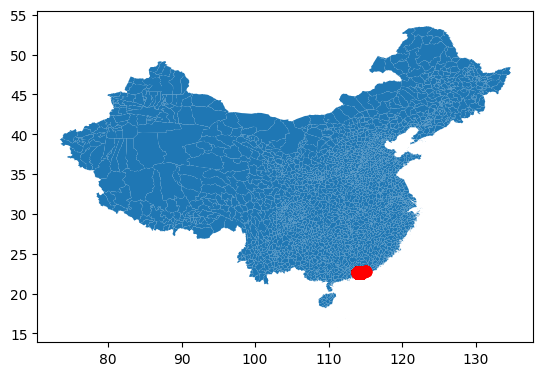

In [300]:
districts.plot()
poi_gdf.plot(ax=plt.gca(), color="red")

In [294]:
poi_per_district['district'].unique()

array(["Bao'an District", 'Longgang District'], dtype=object)

In [292]:
poi_per_district[poi_per_district['latitude'] == 22.78]

Empty DataFrame
Columns: [type, longitude, latitude, district]
Index: []

In [289]:
shenzhen_districts_population

District  Permanent population (2020)  Latitude  Longitude
1        luohu district                      1143801   22.5489   114.1176
2       futian district                      1553225   22.5411   114.0505
3      nanshan district                      1795826   22.5329   113.9303
4       bao'an district                      4476554   22.5667   113.8830
5     longgang district                      3979037   22.7204   114.2514
6      yantian district                       214225   22.5555   114.2350
7      longhua district                      2528872   22.6316   114.0228
8     pingshan district                       551333   22.6910   114.3431
9    guangming district                      1095289   22.7773   113.9378
10  dapeng new district                       156236   22.5946   114.4750

In [345]:
districts['name_en'] = districts['name_en'].str.lower().str.strip()
shenzhen_districts_population['District'] = shenzhen_districts_population['District'].str.lower().str.strip()

In [350]:
districts_clean = districts.dissolve(by="name_en", as_index=False)
districts_clean

name_en                                           geometry  \
0       bao'an district  POLYGON ((113.71408 22.72695, 113.73802 22.728...   
1   dapeng new district  POLYGON ((114.33805 22.62977, 114.33907 22.634...   
2       futian district  POLYGON ((113.98671 22.52203, 113.98602 22.524...   
3    guangming district  POLYGON ((113.85425 22.77458, 113.85207 22.777...   
4     longgang district  MULTIPOLYGON (((114.0481 22.63457, 114.04729 2...   
5      longhua district  POLYGON ((113.96294 22.65503, 113.96458 22.655...   
6        luohu district  POLYGON ((114.0611 22.58915, 114.06116 22.5902...   
7      nanshan district  POLYGON ((113.82231 22.51968, 113.8328 22.5224...   
8     pingshan district  POLYGON ((114.26328 22.65989, 114.26328 22.663...   
9         shenzhen city  MULTIPOLYGON (((113.77023 22.74887, 113.78186 ...   
10     yantian district  POLYGON ((114.19868 22.55691, 114.19876 22.558...   

    name District  Permanent population (2020)  Latitude  Longitude  
0    宝安区     None                          NaN       NaN        NaN  
1   大鹏新区     None                          NaN       NaN        NaN  
2    福田区     None                          NaN       NaN        NaN  
3    光明区     None                          NaN       NaN        NaN  
4    龙岗区     None                          NaN       NaN        NaN  
5    龙华区     None                          NaN       NaN        NaN  
6    罗湖区     None                          NaN       NaN        NaN  
7    南山区     None                          NaN       NaN        NaN  
8    坪山区     None                          NaN       NaN        NaN  
9    深圳市     None                          NaN       NaN        NaN  
10   盐田区     None                          NaN       NaN        NaN

In [351]:
districts = districts_clean.merge(
    shenzhen_districts_population,
    left_on="name_en", right_on="District",
    how="left"
)
districts

name_en                                           geometry  \
0       bao'an district  POLYGON ((113.71408 22.72695, 113.73802 22.728...   
1   dapeng new district  POLYGON ((114.33805 22.62977, 114.33907 22.634...   
2       futian district  POLYGON ((113.98671 22.52203, 113.98602 22.524...   
3    guangming district  POLYGON ((113.85425 22.77458, 113.85207 22.777...   
4     longgang district  MULTIPOLYGON (((114.0481 22.63457, 114.04729 2...   
5      longhua district  POLYGON ((113.96294 22.65503, 113.96458 22.655...   
6        luohu district  POLYGON ((114.0611 22.58915, 114.06116 22.5902...   
7      nanshan district  POLYGON ((113.82231 22.51968, 113.8328 22.5224...   
8     pingshan district  POLYGON ((114.26328 22.65989, 114.26328 22.663...   
9         shenzhen city  MULTIPOLYGON (((113.77023 22.74887, 113.78186 ...   
10     yantian district  POLYGON ((114.19868 22.55691, 114.19876 22.558...   

    name District_x  Permanent population (2020)_x  Latitude_x  Longitude_x  \
0    宝安区       None                            NaN         NaN          NaN   
1   大鹏新区       None                            NaN         NaN          NaN   
2    福田区       None                            NaN         NaN          NaN   
3    光明区       None                            NaN         NaN          NaN   
4    龙岗区       None                            NaN         NaN          NaN   
5    龙华区       None                            NaN         NaN          NaN   
6    罗湖区       None                            NaN         NaN          NaN   
7    南山区       None                            NaN         NaN          NaN   
8    坪山区       None                            NaN         NaN          NaN   
9    深圳市       None                            NaN         NaN          NaN   
10   盐田区       None                            NaN         NaN          NaN   

             District_y  Permanent population (2020)_y  Latitude_y  \
0       bao'an district                      4476554.0     22.5667   
1   dapeng new district                       156236.0     22.5946   
2       futian district                      1553225.0     22.5411   
3    guangming district                      1095289.0     22.7773   
4     longgang district                      3979037.0     22.7204   
5      longhua district                      2528872.0     22.6316   
6        luohu district                      1143801.0     22.5489   
7      nanshan district                      1795826.0     22.5329   
8     pingshan district                       551333.0     22.6910   
9                   NaN                            NaN         NaN   
10     yantian district                       214225.0     22.5555   

    Longitude_y  
0      113.8830  
1      114.4750  
2      114.0505  
3      113.9378  
4      114.2514  
5      114.0228  
6      114.1176  
7      113.9303  
8      114.3431  
9           NaN  
10     114.2350

In [352]:

columns_to_keep = ['name_en', 'geometry', 'District_y', 'Permanent population (2020)_y', 'Latitude_y', 'Longitude_y']
districts_clean = districts[columns_to_keep]

districts_clean = districts_clean.rename(columns={
    'District_y': 'District',
    'Permanent population (2020)_y': 'population',
    'Longitude_y': 'longitude',
    'Latitude_y': 'latitude',
})

In [355]:
districts_clean = districts_clean.dropna()

In [356]:
districts_clean

name_en                                           geometry  \
0       bao'an district  POLYGON ((113.71408 22.72695, 113.73802 22.728...   
1   dapeng new district  POLYGON ((114.33805 22.62977, 114.33907 22.634...   
2       futian district  POLYGON ((113.98671 22.52203, 113.98602 22.524...   
3    guangming district  POLYGON ((113.85425 22.77458, 113.85207 22.777...   
4     longgang district  MULTIPOLYGON (((114.0481 22.63457, 114.04729 2...   
5      longhua district  POLYGON ((113.96294 22.65503, 113.96458 22.655...   
6        luohu district  POLYGON ((114.0611 22.58915, 114.06116 22.5902...   
7      nanshan district  POLYGON ((113.82231 22.51968, 113.8328 22.5224...   
8     pingshan district  POLYGON ((114.26328 22.65989, 114.26328 22.663...   
10     yantian district  POLYGON ((114.19868 22.55691, 114.19876 22.558...   

               District  population  latitude  longitude  
0       bao'an district   4476554.0   22.5667   113.8830  
1   dapeng new district    156236.0   22.5946   114.4750  
2       futian district   1553225.0   22.5411   114.0505  
3    guangming district   1095289.0   22.7773   113.9378  
4     longgang district   3979037.0   22.7204   114.2514  
5      longhua district   2528872.0   22.6316   114.0228  
6        luohu district   1143801.0   22.5489   114.1176  
7      nanshan district   1795826.0   22.5329   113.9303  
8     pingshan district    551333.0   22.6910   114.3431  
10     yantian district    214225.0   22.5555   114.2350

In [359]:
chargers_gdf = gpd.GeoDataFrame(
    sites,
    geometry=gpd.points_from_xy(sites.longitude, sites.latitude),
    crs="EPSG:4326"
)

poi_gdf = gpd.GeoDataFrame(
    poi,
    geometry=gpd.points_from_xy(poi.longitude, poi.latitude),
    crs="EPSG:4326"
)

In [360]:
chargers_gdf

site   longitude   latitude  charger_num  total_duration  total_volume  \
0        0  114.142651  22.547750            4    77594.572675  5.431620e+05   
1        1  114.119416  22.541244            1     9882.750000  6.917925e+04   
2        3  114.109352  22.540594            1     5726.625000  4.014792e+04   
3        4  114.116610  22.579000            1   100576.916667  7.040384e+05   
4        5  114.114493  22.543569            1    32646.833333  2.285278e+05   
...    ...         ...        ...          ...             ...           ...   
1374  1440  114.086330  22.629165            1   197383.733393  3.463798e+07   
1375  1441  114.026166  22.713154            1   188865.688114  2.458308e+07   
1376  1442  113.944227  22.526603            1    19393.958333  6.787885e+04   
1377  1443  114.055040  22.569144            1    13450.916667  4.707821e+04   
1378  1444  114.259875  22.583775            1     3786.583333  1.135975e+05   

       avg_power   perimeter          area                    geometry  
0       7.000000  431.915270  12419.719390  POINT (114.14265 22.54775)  
1       7.000000  275.289766   6011.643662  POINT (114.11942 22.54124)  
2       7.003539  275.289079   6011.615355  POINT (114.10935 22.54059)  
3       7.000000  275.329698   6013.289655    POINT (114.11661 22.579)  
4       7.000000  275.292222   6011.744920  POINT (114.11449 22.54357)  
...          ...         ...           ...                         ...  
1374  175.920328  275.382891   6015.482062  POINT (114.08633 22.62916)  
1375  129.459182  275.472296   6019.166627  POINT (114.02617 22.71315)  
1376    3.500000  275.274304   6011.006324   POINT (113.94423 22.5266)  
1377    3.500000  275.319265   6012.859638  POINT (114.05504 22.56914)  
1378   30.000000  275.334755   6013.498074  POINT (114.25988 22.58378)  

[1377 rows x 10 columns]

In [362]:
poi_gdf = poi_gdf[poi_gdf['type'].isin(poi_type_to_keep)]

In [364]:
chargers_per_district = gpd.sjoin(chargers_gdf, districts_clean, how="left", predicate="within")
poi_per_district = gpd.sjoin(poi_gdf, districts_clean, how="left", predicate="within")

In [399]:
poi_per_district = poi_per_district.drop(columns=['Unnamed: 0', 'index_right', 'latitude_right', 'longitude_right'])

In [404]:
poi_per_district = poi_per_district.rename(columns={'name_en': 'district'})
poi_per_district = poi_per_district.drop(columns=['District'])

In [405]:
poi_per_district

type  longitude_left  latitude_left  \
5              hospital      114.081323      22.540285   
8                cinema      114.113790      22.547825   
24             hospital      114.116354      22.550331   
26                 taxi      114.113008      22.533869   
29              parking      114.043383      22.549317   
...                 ...             ...            ...   
46865           parking      114.250127      22.697236   
46866           parking      114.250016      22.696890   
46883       marketplace      114.114538      22.620088   
46928  place_of_worship      114.072758      22.685720   
47007           parking      114.129286      22.615298   

                         geometry           district  population  
5      POINT (114.08132 22.54028)    futian district   1553225.0  
8      POINT (114.11379 22.54782)     luohu district   1143801.0  
24     POINT (114.11635 22.55033)     luohu district   1143801.0  
26     POINT (114.11301 22.53387)     luohu district   1143801.0  
29     POINT (114.04338 22.54932)    futian district   1553225.0  
...                           ...                ...         ...  
46865  POINT (114.25013 22.69724)  longgang district   3979037.0  
46866  POINT (114.25002 22.69689)  longgang district   3979037.0  
46883  POINT (114.11454 22.62009)  longgang district   3979037.0  
46928  POINT (114.07276 22.68572)   longhua district   2528872.0  
47007   POINT (114.12929 22.6153)  longgang district   3979037.0  

[1935 rows x 6 columns]

In [374]:
import geopandas as gpd
from shapely.geometry import Point

gdf_daily = gpd.GeoDataFrame(
    df_daily,
    geometry=gpd.points_from_xy(df_daily.longitude, df_daily.latitude),
    crs="EPSG:4326")

In [372]:

districts_clean = gpd.GeoDataFrame(districts_clean, geometry='geometry', crs="EPSG:4326")

In [375]:
# This will add the district info (name, population, etc.) to each charging station
gdf_full_updated = gpd.sjoin(gdf_daily, districts_clean, how='left', predicate='within')

In [384]:
gdf_full_updated = gdf_full_updated.drop(columns=['district', 'District', 'population_right', 'latitude_right', 'longitude_right'])

In [393]:
gdf_full_updated['name_en'].unique()

array(['luohu district', 'futian district', 'longgang district',
       "bao'an district", 'nanshan district', 'longhua district',
       'pingshan district', 'guangming district', 'yantian district',
       'dapeng new district'], dtype=object)

In [391]:
gdf_full_updated = gdf_full_updated.dropna()

In [394]:
gdf_full_updated.head()

site_id  timestamp  e_price  s_price  longitude_left  latitude_left  \
0       0 2023-04-01      0.7      0.9      114.142651       22.54775   
1       0 2023-04-02      0.7      0.9      114.142651       22.54775   
2       0 2023-04-03      0.7      0.9      114.142651       22.54775   
3       0 2023-04-04      0.7      0.9      114.142651       22.54775   
4       0 2023-04-05      0.7      0.9      114.142651       22.54775   

   num_of_chargers  avg_power charger_type      revenue         cost  \
0                4        7.0      AC_fast  1850.080734   809.410321   
1                4        7.0      AC_fast  1995.843425   873.181498   
2                4        7.0      AC_fast  2501.872783  1094.569343   
3                4        7.0      AC_fast  1872.968807   819.423853   
4                4        7.0      AC_fast  1863.798165   815.411697   

        profit       volume  total_volume  total_duration  population_left  \
0  1040.670413  1156.300459  284993.16577    41664.097558        1143801.0   
1  1122.661927  1247.402141  284993.16577    41664.097558        1143801.0   
2  1407.303440  1563.670489  284993.16577    41664.097558        1143801.0   
3  1053.544954  1170.605505  284993.16577    41664.097558        1143801.0   
4  1048.386468  1164.873853  284993.16577    41664.097558        1143801.0   

                     geometry         name_en  
0  POINT (114.14265 22.54775)  luohu district  
1  POINT (114.14265 22.54775)  luohu district  
2  POINT (114.14265 22.54775)  luohu district  
3  POINT (114.14265 22.54775)  luohu district  
4  POINT (114.14265 22.54775)  luohu district

In [396]:
gdf_full_updated = gdf_full_updated.rename(columns={'name_en': 'district'})
gdf_full_updated

site_id  timestamp  e_price  s_price  longitude_left  latitude_left  \
0            0 2023-04-01      0.7      0.9      114.142651      22.547750   
1            0 2023-04-02      0.7      0.9      114.142651      22.547750   
2            0 2023-04-03      0.7      0.9      114.142651      22.547750   
3            0 2023-04-04      0.7      0.9      114.142651      22.547750   
4            0 2023-04-05      0.7      0.9      114.142651      22.547750   
...        ...        ...      ...      ...             ...            ...   
248509     999 2023-09-26      0.7      0.9      114.039323      22.550918   
248510     999 2023-09-27      0.7      0.9      114.039323      22.550918   
248511     999 2023-09-28      0.7      0.9      114.039323      22.550918   
248512     999 2023-09-29      0.7      0.9      114.039323      22.550918   
248513     999 2023-09-30      0.7      0.9      114.039323      22.550918   

        num_of_chargers  avg_power charger_type      revenue         cost  \
0                     4        7.0      AC_fast  1850.080734   809.410321   
1                     4        7.0      AC_fast  1995.843425   873.181498   
2                     4        7.0      AC_fast  2501.872783  1094.569343   
3                     4        7.0      AC_fast  1872.968807   819.423853   
4                     4        7.0      AC_fast  1863.798165   815.411697   
...                 ...        ...          ...          ...          ...   
248509                2        7.0      AC_fast  1689.600000   739.200000   
248510                2        7.0      AC_fast  1689.600000   739.200000   
248511                2        7.0      AC_fast  1689.600000   739.200000   
248512                2        7.0      AC_fast  1689.600000   739.200000   
248513                2        7.0      AC_fast  1689.600000   739.200000   

             profit       volume  total_volume  total_duration  \
0       1040.670413  1156.300459  284993.16577    41664.097558   
1       1122.661927  1247.402141  284993.16577    41664.097558   
2       1407.303440  1563.670489  284993.16577    41664.097558   
3       1053.544954  1170.605505  284993.16577    41664.097558   
4       1048.386468  1164.873853  284993.16577    41664.097558   
...             ...          ...           ...             ...   
248509   950.400000  1056.000000  193248.00000    95662.991667   
248510   950.400000  1056.000000  193248.00000    95662.991667   
248511   950.400000  1056.000000  193248.00000    95662.991667   
248512   950.400000  1056.000000  193248.00000    95662.991667   
248513   950.400000  1056.000000  193248.00000    95662.991667   

        population_left                    geometry         district  
0             1143801.0  POINT (114.14265 22.54775)   luohu district  
1             1143801.0  POINT (114.14265 22.54775)   luohu district  
2             1143801.0  POINT (114.14265 22.54775)   luohu district  
3             1143801.0  POINT (114.14265 22.54775)   luohu district  
4             1143801.0  POINT (114.14265 22.54775)   luohu district  
...                 ...                         ...              ...  
248509        1553225.0  POINT (114.03932 22.55092)  futian district  
248510        1553225.0  POINT (114.03932 22.55092)  futian district  
248511        1553225.0  POINT (114.03932 22.55092)  futian district  
248512        1553225.0  POINT (114.03932 22.55092)  futian district  
248513        1553225.0  POINT (114.03932 22.55092)  futian district  

[249246 rows x 18 columns]

In [441]:
district_coverage = gdf_full_updated.groupby('district').agg({
    'site_id': 'nunique',
    'volume': 'sum',
    'population_left': 'mean' 
}).reset_index().rename(columns={
    'site_id': 'num_sites',
    'volume': 'total_volume',
    'population_left': 'population'
    
})

In [451]:
district_coverage['volume_per_capita'] = district_coverage['total_volume'] / district_coverage['population']
district_coverage['sites_per_100k'] = district_coverage['num_sites'] / (district_coverage['population'] / 100000)
district_coverage['total_volume'] = round(district_coverage['total_volume'])

In [452]:
district_coverage

district  num_sites  total_volume    population  \
0      bao'an district        185   329059045.0  4.476554e+06   
1  dapeng new district          7      327611.0  3.979037e+06   
2      futian district        224    14017181.0  1.553225e+06   
3   guangming district         38    15490970.0  1.095289e+06   
4    longgang district        327   147196862.0  3.979037e+06   
5     longhua district        128    38068778.0  2.528872e+06   
6       luohu district        155    39933119.0  1.180385e+06   
7     nanshan district        239    31329006.0  1.793796e+06   
8    pingshan district         36    12918421.0  5.513330e+05   
9     yantian district         23     1282624.0  2.142250e+05   

   volume_per_capita  sites_per_100k  underserved_index  
0          73.507221        4.132643          17.786975  
1           0.082334        0.175922           0.468016  
2           9.024566       14.421607           0.625767  
3          14.143272        3.469404           4.076571  
4          36.993087        8.218069           4.501433  
5          15.053659        5.061545           2.974123  
6          33.830597       13.131312           2.576330  
7          17.465201       13.323701           1.310837  
8          23.431249        6.529629           3.588450  
9           5.987275       10.736375           0.557662

In [453]:
print(district_coverage['volume_per_capita'] / district_coverage['sites_per_100k'])

0    17.786975
1     0.468016
2     0.625767
3     4.076571
4     4.501433
5     2.974123
6     2.576330
7     1.310837
8     3.588450
9     0.557663
dtype: float64


In [420]:
poi_per_district

type  longitude_left  latitude_left  \
5              hospital      114.081323      22.540285   
8                cinema      114.113790      22.547825   
24             hospital      114.116354      22.550331   
26                 taxi      114.113008      22.533869   
29              parking      114.043383      22.549317   
...                 ...             ...            ...   
46865           parking      114.250127      22.697236   
46866           parking      114.250016      22.696890   
46883       marketplace      114.114538      22.620088   
46928  place_of_worship      114.072758      22.685720   
47007           parking      114.129286      22.615298   

                         geometry           district  population  
5      POINT (114.08132 22.54028)    futian district   1553225.0  
8      POINT (114.11379 22.54782)     luohu district   1143801.0  
24     POINT (114.11635 22.55033)     luohu district   1143801.0  
26     POINT (114.11301 22.53387)     luohu district   1143801.0  
29     POINT (114.04338 22.54932)    futian district   1553225.0  
...                           ...                ...         ...  
46865  POINT (114.25013 22.69724)  longgang district   3979037.0  
46866  POINT (114.25002 22.69689)  longgang district   3979037.0  
46883  POINT (114.11454 22.62009)  longgang district   3979037.0  
46928  POINT (114.07276 22.68572)   longhua district   2528872.0  
47007   POINT (114.12929 22.6153)  longgang district   3979037.0  

[1935 rows x 6 columns]

In [421]:
for _, row in poi_per_district.iterrows():
    folium.CircleMarker(
        location=[row['latitude_left'], row['longitude_left']],
        radius=2,
        color='yellow',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_szx)
map_szx

In [422]:
districts_clean

name_en                                           geometry  \
0       bao'an district  POLYGON ((113.71408 22.72695, 113.73802 22.728...   
1   dapeng new district  POLYGON ((114.33805 22.62977, 114.33907 22.634...   
2       futian district  POLYGON ((113.98671 22.52203, 113.98602 22.524...   
3    guangming district  POLYGON ((113.85425 22.77458, 113.85207 22.777...   
4     longgang district  MULTIPOLYGON (((114.0481 22.63457, 114.04729 2...   
5      longhua district  POLYGON ((113.96294 22.65503, 113.96458 22.655...   
6        luohu district  POLYGON ((114.0611 22.58915, 114.06116 22.5902...   
7      nanshan district  POLYGON ((113.82231 22.51968, 113.8328 22.5224...   
8     pingshan district  POLYGON ((114.26328 22.65989, 114.26328 22.663...   
10     yantian district  POLYGON ((114.19868 22.55691, 114.19876 22.558...   

               District  population  latitude  longitude  
0       bao'an district   4476554.0   22.5667   113.8830  
1   dapeng new district    156236.0   22.5946   114.4750  
2       futian district   1553225.0   22.5411   114.0505  
3    guangming district   1095289.0   22.7773   113.9378  
4     longgang district   3979037.0   22.7204   114.2514  
5      longhua district   2528872.0   22.6316   114.0228  
6        luohu district   1143801.0   22.5489   114.1176  
7      nanshan district   1795826.0   22.5329   113.9303  
8     pingshan district    551333.0   22.6910   114.3431  
10     yantian district    214225.0   22.5555   114.2350

In [454]:
district_coverage['underserved_index'] = district_coverage['volume_per_capita'] / district_coverage['sites_per_100k']

# merge with district geometries
districts_gdf = districts_clean.merge(
    district_coverage,
    left_on='District',
    right_on='district',
    how='left'
)

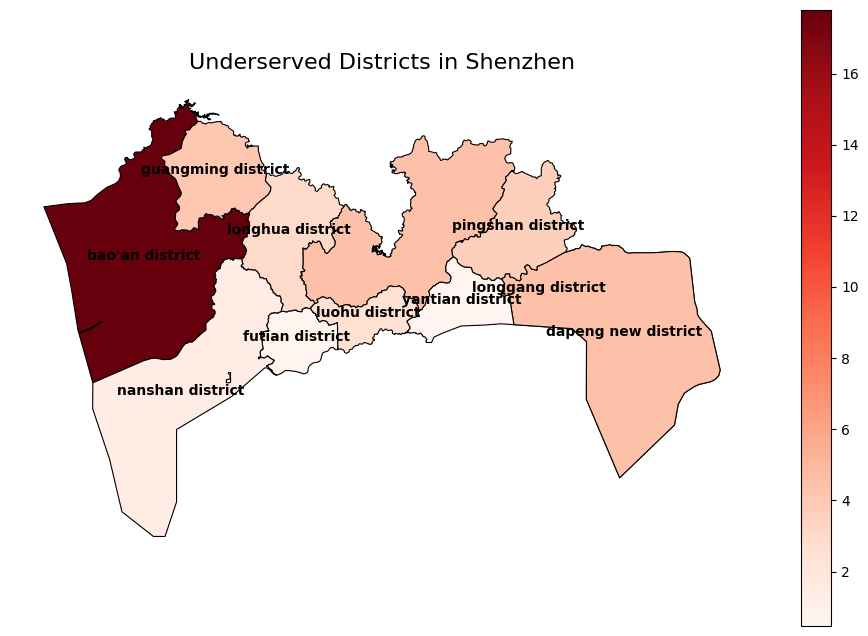

In [455]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

districts_gdf.plot(
    column='underserved_index',
    cmap='Reds',
    legend=True,
    edgecolor='black',
    linewidth=0.8,
    ax=ax
)

# add labels at centroids
for idx, row in districts_gdf.iterrows():
    plt.text(
        x=row['geometry'].centroid.x, 
        y=row['geometry'].centroid.y, 
        s=row['district'],  # district name
        horizontalalignment='center',
        fontsize=10,
        fontweight='bold',
        color='black'
    )

ax.set_title('Underserved Districts in Shenzhen', fontsize=16)
ax.axis('off')
plt.show()

In [428]:
from shapely.geometry import Point

In [456]:
districts_gdf = districts_gdf.drop(columns=['name_en', 'population_y', 'District'])

In [457]:
place_1 = gpd.GeoDataFrame(
    geometry=[Point(113.844234, 22.810568)],
    crs='EPSG:4326'
)

place_1['district'] = gpd.sjoin(place_1, districts_gdf, how='left', predicate='within')['district']

In [458]:
place_1

geometry         district
0  POINT (113.84423 22.81057)  bao'an district

In [459]:
district_coverage

district  num_sites  total_volume    population  \
0      bao'an district        185   329059045.0  4.476554e+06   
1  dapeng new district          7      327611.0  3.979037e+06   
2      futian district        224    14017181.0  1.553225e+06   
3   guangming district         38    15490970.0  1.095289e+06   
4    longgang district        327   147196862.0  3.979037e+06   
5     longhua district        128    38068778.0  2.528872e+06   
6       luohu district        155    39933119.0  1.180385e+06   
7     nanshan district        239    31329006.0  1.793796e+06   
8    pingshan district         36    12918421.0  5.513330e+05   
9     yantian district         23     1282624.0  2.142250e+05   

   volume_per_capita  sites_per_100k  underserved_index  
0          73.507221        4.132643          17.786975  
1           0.082334        0.175922           0.468016  
2           9.024566       14.421607           0.625767  
3          14.143272        3.469404           4.076571  
4          36.993087        8.218069           4.501433  
5          15.053659        5.061545           2.974123  
6          33.830597       13.131312           2.576330  
7          17.465201       13.323701           1.310837  
8          23.431249        6.529629           3.588450  
9           5.987275       10.736375           0.557663

In [449]:

district_coverage.loc[district_coverage['district'] == 'guangming district', 'population'] = 1095289

In [460]:
district_coverage

district  num_sites  total_volume    population  \
0      bao'an district        185   329059045.0  4.476554e+06   
1  dapeng new district          7      327611.0  3.979037e+06   
2      futian district        224    14017181.0  1.553225e+06   
3   guangming district         38    15490970.0  1.095289e+06   
4    longgang district        327   147196862.0  3.979037e+06   
5     longhua district        128    38068778.0  2.528872e+06   
6       luohu district        155    39933119.0  1.180385e+06   
7     nanshan district        239    31329006.0  1.793796e+06   
8    pingshan district         36    12918421.0  5.513330e+05   
9     yantian district         23     1282624.0  2.142250e+05   

   volume_per_capita  sites_per_100k  underserved_index  
0          73.507221        4.132643          17.786975  
1           0.082334        0.175922           0.468016  
2           9.024566       14.421607           0.625767  
3          14.143272        3.469404           4.076571  
4          36.993087        8.218069           4.501433  
5          15.053659        5.061545           2.974123  
6          33.830597       13.131312           2.576330  
7          17.465201       13.323701           1.310837  
8          23.431249        6.529629           3.588450  
9           5.987275       10.736375           0.557663

In [461]:
place_1 = place_1.merge(
    district_coverage[['district','population','total_volume','volume_per_capita','sites_per_100k']],
    left_on='district',
    right_on='district',
    how='left'
)

In [469]:
place_1 = place_1.merge(
    land_price[['district','price']],
    left_on='district',
    right_on='district',
    how='left'
)

In [472]:
place_1.drop(columns=['price_x'], inplace=True)

In [474]:
place_1.rename(columns={'price_y': 'price_m2'})

geometry         district  population  total_volume  \
0  POINT (113.84423 22.81057)  bao'an district   4476554.0   329059045.0   

   volume_per_capita  sites_per_100k  price_m2  
0          73.507221        4.132643   35047.1

In [475]:
def estimate_cost_DC_fast(num_ports, district, base_min=98000, base_max=200000):
    multiplier = district_multipliers.get(district, 1.0)
    avg_base_cost = (base_min + base_max) / 2
    return num_ports * avg_base_cost * multiplier

In [477]:
place_1['estimated_cost'] = estimate_cost_DC_fast(num_ports=4, district=place_1['district'].iloc[0])

In [478]:
place_1

geometry         district  population  total_volume  \
0  POINT (113.84423 22.81057)  bao'an district   4476554.0   329059045.0   

   volume_per_capita  sites_per_100k  price_y  estimated_cost  
0          73.507221        4.132643  35047.1        655600.0

## Next steps
### fix the cost function so it uses district land price, charger type/qty, and misc costs; (2) show how to attach a candidate site (lat/lon) to district + population/consumption/land price; and (3) estimate ROI using nearest neighbors (KNN)

## 2nd Goal: 
### Create an interactive Streamlit website where you can mark on map the location you want to place a charging station (can be that the map will give you latitude and longitude and you fill in a blank or directly click on map). Then fill a blank of how many chargers you want to place, what type of charger and my model will predict the price you need to invest for build the station (depends the location, charger type, num of chargers...) and predict the daily, weekly, monthly profit and with that predict ROI. 